# Online Offers Detector

In [19]:
# We first import the libraries that we'll use
from pytesseract import (Output, 
                         TesseractError,
                         TesseractNotFoundError,
                         TSVNotSupported,
                         get_tesseract_version,
                         image_to_boxes,
                         image_to_data,
                         image_to_osd,
                         image_to_pdf_or_hocr,
                         image_to_string,
                         run_and_get_output)
import ocr_source.custom_callbacks as custom_callbacks
import ocr_source.batch_functions as batch_functions
import ocr_source.inference as inference
import ocr_source.models as models
import ocr_source.losses as losses
import os
import cv2
import time
import twint
import requests
import importlib
import pytesseract
import PIL.ImageOps
import nest_asyncio
import arrand.arrandom as ar
import tensorflow as tf
import numpy as np
from tensorflow.keras.layers import (MaxPooling2D,Flatten, LeakyReLU, LSTM, 
                                     Bidirectional, Dense, Conv2D, TimeDistributed, Input)
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.python.client import device_lib
from tensorflow.keras.models import Model
from tensorflow.compat.v1 import ConfigProto
from tensorflow.compat.v1 import InteractiveSession
from trdg.generators import GeneratorFromRandom, GeneratorFromDict
from IPython.display import HTML
from tensorflow import keras
from matplotlib import pyplot as plt
from ArabicOcr import arabicocr
from PIL import Image as im
from io import BytesIO
nest_asyncio.apply()

# Web Scraping

We will now scrape twitter for the images that contains the offers

In [3]:
def get_images_from_twitter(username = 'DunkinDonutsKSA', search = ['عرض']):
    c = twint.Config()
    c.Limit = 20
    c.Images= True
    c.Username = username
    c.Search = search
    c.Pandas = True
    c.Store_csv = True
    c.Custom["tweet"] = ["photos", "tweet"]
    c.Output = ("scrap.csv")
    twint.run.Search(c)
    Tweets_df = twint.storage.panda.Tweets_df
    num = 0
    for i in Tweets_df.photos:
        response = requests.get(Tweets_df.photos[num][0])
        img = im.open(BytesIO(response.content))
        img.convert('RGB').save(f'scraped_imgs\\{num}.jpg','JPEG')
        num+=1

# Model

We will now develop the model 

In [4]:
#check the gpu
print(tf.config.list_physical_devices('GPU'))

#for tf2 magic lines to prevent razer from crashing
physical_devices = tf.config.experimental.list_physical_devices('GPU')
config = ConfigProto()
config.gpu_options.per_process_gpu_memory_fraction = 0.7
config.gpu_options.allow_growth = True
session = InteractiveSession(config=config)

[]


In [5]:
# We will now create our parameters
batch_size = 12
img_h = 32

In [6]:
# we will now create a list of all characters
# map each characters to an integer, a "label" and reverse mapping
all_chars = "0123456789abcdefghijklmnopqrstuvwxyzABCDEFGHIJKLMNOPQRSTUVWXYZ"
num_chars = len(all_chars)
char_to_lbl_dict = dict((char, ind) for ind, char in enumerate(all_chars))
lbl_to_char_dict = dict((ind, char) for ind, char in enumerate(all_chars))

In [7]:
# We will now generate data to be used by our model in training
# using trdg for the base generator of text
base_generator = GeneratorFromRandom(use_numbers=True, use_symbols=False,
                                     use_letters=True, background_type=0,
                                     random_blur=True, text_color='#000000')

# adding some more augmentation with keras ImageDataGenerator
keras_augm = ImageDataGenerator(rotation_range=2.0, width_shift_range=5.0, height_shift_range=5.0,
                                shear_range=4.0, zoom_range=0.1)

#the actual datagenerator for training and visualizations (and validation)
dg_params = {"batch_size": batch_size,"img_h": img_h, "keras_augmentor": keras_augm,
             "char_to_lbl_dict": char_to_lbl_dict}

datagen = batch_functions.OCR_generator(base_generator, **dg_params)
val_datagen = batch_functions.OCR_generator(base_generator, **dg_params, validation=True)

## Model 2

In [30]:
input_img = Input(name='the_input', shape=(None, img_h, 3))

# CNN block
x = Conv2D(8, 3, activation="relu", padding="same")(input_img)
x = Conv2D(16, 3, activation="relu", padding="same")(x)
x = MaxPooling2D()(x)

x = Conv2D(32, 3, activation="relu", padding="same")(x)
x = Conv2D(64, 3, activation="relu", padding="same")(x)
x = MaxPooling2D()(x)

# flatten the height and channels to one dimension, after this the dimensionz
# is batch, width, len(height)*len(channels)
tdist = TimeDistributed(Flatten(), name='timedistrib')(x)

# map to encoding dimension for rnn (or just next dense if rnn skipped):
rnn_in = Dense(128, activation="relu", name='dense_in')(tdist)

# lstm encoding layers
x = Bidirectional(LSTM(64, return_sequences=True))(rnn_in)
x = Bidirectional(LSTM(64, return_sequences=True))(x)


y_pred = Dense(num_chars+1, name="predictions", activation='softmax')(x)

#construct the model
model = Model(inputs=input_img, outputs=y_pred)

In [31]:
# CALLBACKS AND LOSSES
# get the cool outputs
predvis = custom_callbacks.PredVisualize(model,val_datagen, lbl_to_char_dict, printing=True)
model_saver = custom_callbacks.make_save_model_cb()
custom_loss = losses.custom_ctc()

In [32]:
# COMPILE, SAVE MODEL
model.compile(loss=custom_loss, optimizer="Adam", metrics=['accuracy'])
tf.keras.models.save_model(model, "saved_models", overwrite=True, include_optimizer=False)

INFO:tensorflow:Assets written to: saved_models\assets


Epoch 1/20
500/500 [==============================] - ETA: 0s - loss: 27.0828 - accuracy: 0.0000e+00

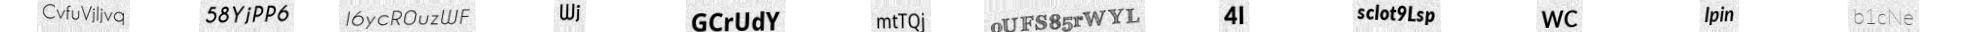

predictions ['', '', '', '', '', '', '', '', '', '', '', '']
500/500 [==============================] - 93s 186ms/step - loss: 27.0828 - accuracy: 0.0000e+00
Epoch 2/20
500/500 [==============================] - ETA: 0s - loss: 25.9783 - accuracy: 0.0000e+00

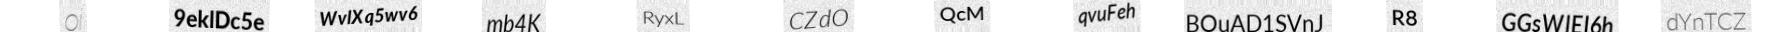

predictions ['', '', '', '', '', '', '', '', '', '', '', '']
500/500 [==============================] - 90s 180ms/step - loss: 25.9783 - accuracy: 0.0000e+00
Epoch 3/20
500/500 [==============================] - ETA: 0s - loss: 25.5686 - accuracy: 0.0000e+00

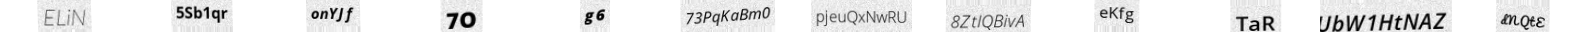

predictions ['', '', '', '', '', '', '', '', '', '', '', '']
500/500 [==============================] - 90s 179ms/step - loss: 25.5686 - accuracy: 0.0000e+00
Epoch 4/20
500/500 [==============================] - ETA: 0s - loss: 25.3357 - accuracy: 0.0000e+00

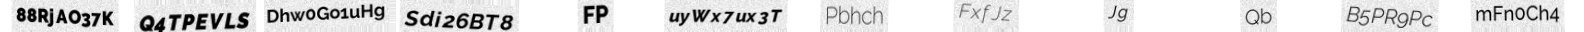

predictions ['c', 'W', 'W', 'W', '', 'W', 'P', 'V', '', '', 'w', 'W']
500/500 [==============================] - 88s 175ms/step - loss: 25.3357 - accuracy: 0.0000e+00
Epoch 5/20
500/500 [==============================] - ETA: 0s - loss: 25.0410 - accuracy: 9.9077e-06

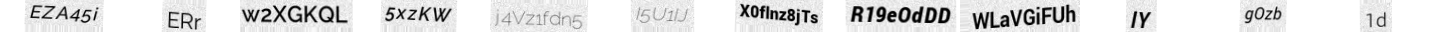

predictions ['p', 'b', '3', 'p', 'w', 'O', 'q', '8', '8', 'E', 'p', 'g']
500/500 [==============================] - 89s 177ms/step - loss: 25.0410 - accuracy: 9.9077e-06
Epoch 6/20
500/500 [==============================] - ETA: 0s - loss: 24.4422 - accuracy: 0.0000e+00

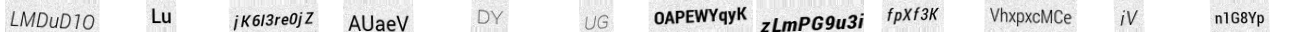

predictions ['U', 'O', 'U', 'U', 'O', 'aw', '8', '8', 'q', '3', 'g', 'q']
500/500 [==============================] - 87s 174ms/step - loss: 24.4422 - accuracy: 0.0000e+00
Epoch 7/20
500/500 [==============================] - ETA: 0s - loss: 22.8417 - accuracy: 2.9723e-05

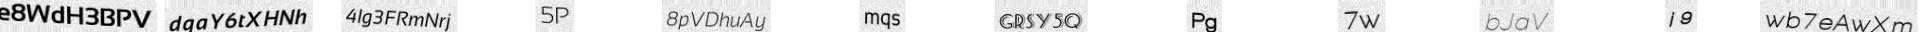

predictions ['xABvH', 'dWHH5', 'M8Fmj', 'O', 'xDh', 'mA', '2xPh', 'Fs', 'A', 'O', 'Fs', 'Yc']
500/500 [==============================] - 88s 175ms/step - loss: 22.8417 - accuracy: 2.9723e-05
Epoch 8/20
500/500 [==============================] - ETA: 0s - loss: 16.8226 - accuracy: 4.4089e-04

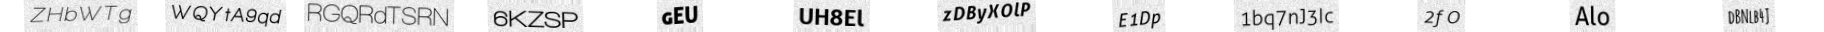

predictions ['ZHDWTO', 'WQABqq', 'HBDGRh', 'GZGP', 'xEH', 'HH8EH', '7D8WWDE', 'F1pp', 'Tbq7m8F', '2TO', 'Ap', 'iqMj']
500/500 [==============================] - 87s 174ms/step - loss: 16.8226 - accuracy: 4.4089e-04
Epoch 9/20
500/500 [==============================] - ETA: 0s - loss: 9.8784 - accuracy: 0.0019

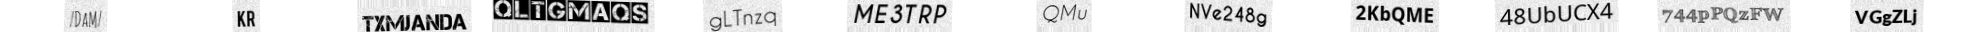

predictions ['1gdMl', 'KR', 'TXMlAND5', 'S13mdQS', 'gTnzq', 'ME3TRP', 'QMu', 'MWx248g', '2KbQME', '48UbUCA', '744p2QxZW', 'VGg2H']
500/500 [==============================] - 87s 175ms/step - loss: 9.8784 - accuracy: 0.0019
Epoch 10/20
500/500 [==============================] - ETA: 0s - loss: 6.5337 - accuracy: 0.0026

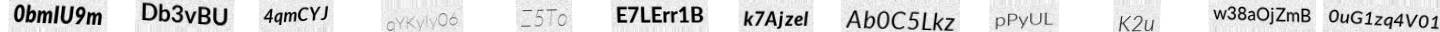

predictions ['QbmU9m', 'Db3vBU', '4qmCYJ', 'eVwyyQ6', 'ZSTa', 'E7LErr1B', 'k7Ajzej', 'Ab0CSLkz', 'pPyUL', 'K2u', 'w38aOjZmB', 'OuG1zq4VOj']
500/500 [==============================] - 88s 176ms/step - loss: 6.5337 - accuracy: 0.0026
Epoch 11/20
500/500 [==============================] - ETA: 0s - loss: 4.7883 - accuracy: 0.0026

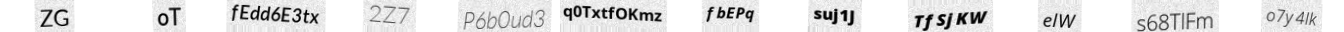

predictions ['ZG', 'aT', 'fEdd6E3x', '2Z7', 'P4bGud3', 'q0TxtOKmz', 'fbEPq', 'suj1J', '7fSjKW', 'eIW', 's58TlFm', 'aZy4Jk']
500/500 [==============================] - 87s 174ms/step - loss: 4.7883 - accuracy: 0.0026
Epoch 12/20
500/500 [==============================] - ETA: 0s - loss: 3.6710 - accuracy: 0.0027

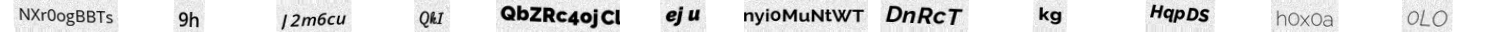

predictions ['NXr0ogBBTs', '3h', 'j2m6cu', 'Qk1', 'QbZRc4ojCl', 'gju', 'nytoMuNtT', 'DnRc7', 'kg', 'HqpDs', 'hOxOa', 'OLO']
500/500 [==============================] - 88s 176ms/step - loss: 3.6710 - accuracy: 0.0027
Epoch 13/20
500/500 [==============================] - ETA: 0s - loss: 3.0363 - accuracy: 0.0027

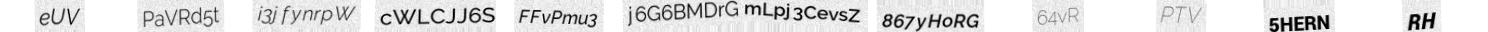

predictions ['gUV', 'PaVRd5t', 'i3jfynrpW', 'cWLCJJ6S', 'FFvPmu3', 'j6G6BMDrG', 'mLpj3CevsZ', '867yHoRG', 'B4vR', 'PTV', '5HERN', 'RH']
500/500 [==============================] - 87s 175ms/step - loss: 3.0363 - accuracy: 0.0027
Epoch 14/20
500/500 [==============================] - ETA: 0s - loss: 2.5641 - accuracy: 0.0028

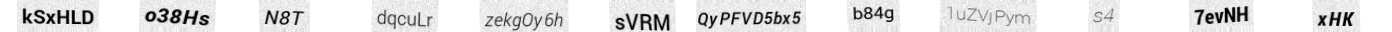

predictions ['kSxHLD', 'o38Hs', 'N8T', 'dqcuLr', 'zekgOy6h', 'sVRM', '0yPFVD5bx5', 'b8Ag', 'iuZVjPym', 's4', '7evNH', 'xHK']
500/500 [==============================] - 90s 180ms/step - loss: 2.5641 - accuracy: 0.0028
Epoch 15/20
500/500 [==============================] - ETA: 0s - loss: 2.1362 - accuracy: 0.0027

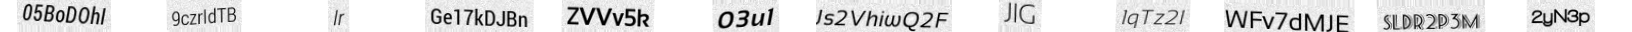

predictions ['05BoD0hl', 'gcztldTB', 'ir', 'Ge17kDJBn', 'ZVVv5k', '03u1', 'ls2VhiwQ2F', 'JlG', 'tqTz2l', 'WFv7dMJE', 'Slbp2p3M', '2yNp']
500/500 [==============================] - 89s 179ms/step - loss: 2.1362 - accuracy: 0.0027
Epoch 16/20
500/500 [==============================] - ETA: 0s - loss: 1.7875 - accuracy: 0.0027

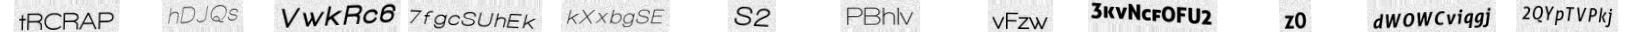

predictions ['tRCRAP', 'hDJQs', 'VwkRc6', '7fgcSUhEk', 'kXxbgSE', 'S2', 'PBhv', 'vFzw', '3kvMcF0FU2', 'zO', 'dW0WCviqgj', '2QYpTVPkj']
500/500 [==============================] - 88s 176ms/step - loss: 1.7875 - accuracy: 0.0027
Epoch 17/20
500/500 [==============================] - ETA: 0s - loss: 1.6150 - accuracy: 0.0029

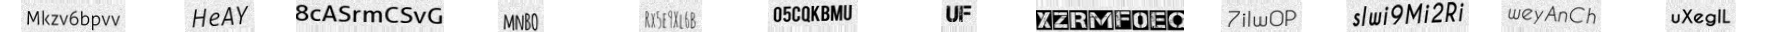

predictions ['Mkzv6bPvv', 'HeAY', '8cASrmCSvG', 'mnBO', '1xeYXl6B', '05C0KBmu', 'UF', 'xZrMf0ES', '7iIu0P', 'slwi9Mi2Ri', 'weyAnCh', 'uXeglL']
500/500 [==============================] - 91s 182ms/step - loss: 1.6150 - accuracy: 0.0029
Epoch 18/20
500/500 [==============================] - ETA: 0s - loss: 1.4139 - accuracy: 0.0027

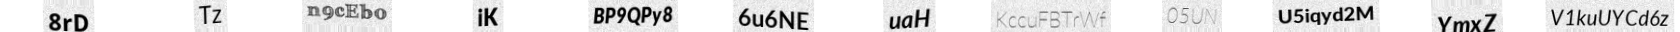

predictions ['8rD', 'Tz', '09cBb0', 'iK', 'BP9QPy8', '6u6NE', 'uaH', 'KccuFBTrWf', '05UN', 'U5iqyd2M', 'YmxZ', 'V1kuUYCd6z']
500/500 [==============================] - 94s 188ms/step - loss: 1.4139 - accuracy: 0.0027
Epoch 19/20
500/500 [==============================] - ETA: 0s - loss: 1.2225 - accuracy: 0.0027

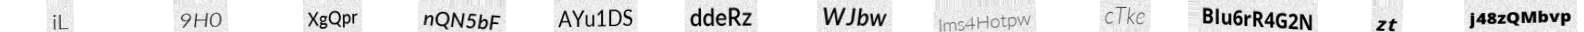

predictions ['iL', '9H0', 'XgQpr', 'nQN5bF', 'AYu1DS', 'ddeRz', 'WJbw', 'ims4Hotpw', 'cTkc', 'BIu6rR4G2N', 'zt', 'j48zQMbvP']
500/500 [==============================] - 90s 180ms/step - loss: 1.2225 - accuracy: 0.0027
Epoch 20/20
500/500 [==============================] - ETA: 0s - loss: 1.1004 - accuracy: 0.0027

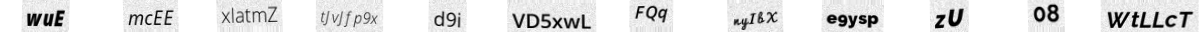

predictions ['wuE', 'mcEE', 'xlatmZ', 'JvJfpx', 'd9i', 'VD5xwL', 'FQq', 'ey1bX', 'e9ysp', 'zU', 'G8', 'WtLLcT']
500/500 [==============================] - 98s 197ms/step - loss: 1.1004 - accuracy: 0.0027


In [33]:
H = model.fit(datagen, epochs=20, verbose=1, callbacks=[predvis, model_saver])

## Model 3

In [3]:
input_img = Input(name='the_input', shape=(None, img_h, 3))

# CNN block
x = Conv2D(8, 3, activation="relu", padding="same")(input_img)
x = Conv2D(16, 3, activation="relu", padding="same")(x)
x = MaxPooling2D()(x)

x = Conv2D(32, 3, activation="relu", padding="same")(x)
x = Conv2D(64, 3, activation="relu", padding="same")(x)
x = MaxPooling2D()(x)

# flatten the height and channels to one dimension, after this the dimension
# is batch, width, len(height)*len(channels)
tdist = TimeDistributed(Flatten(), name='timedistrib')(x)

# lstm encoding layers
x = Bidirectional(LSTM(128, return_sequences=True))(tdist)
x = Bidirectional(LSTM(64, return_sequences=True))(x)
x = Bidirectional(LSTM(64, return_sequences=True))(x)

y_pred = Dense(num_chars+1, name="predictions", activation='softmax')(rnn_in)

#construct the model
model = Model(inputs=input_img, outputs=y_pred)


#********CALLBACKS AND LOSSES****************
# get the cool outputs
predvis = custom_callbacks.PredVisualize(model,val_datagen, lbl_to_char_dict, printing=True)
model_saver = custom_callbacks.make_save_model_cb()
custom_loss = losses.custom_ctc()


#********COMPILE, SAVE MODEL**************
model.compile(loss=custom_loss, optimizer="Adam", metrics=['accuracy'])
tf.keras.models.save_model(model, "saved_models", overwrite=True, include_optimizer=False)

[]


INFO:tensorflow:Assets written to: saved_models\assets


INFO:tensorflow:Assets written to: saved_models\assets


Epoch 1/20
500/500 [==============================] - ETA: 0s - loss: 28.5143 - accuracy: 0.0000e+00

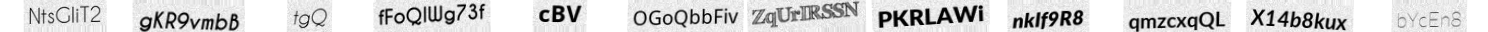

predictions ['', '', '', '', '', '', '', '', '', '', '', '']
500/500 [==============================] - 126s 235ms/step - loss: 28.5143 - accuracy: 0.0000e+00
Epoch 2/20
500/500 [==============================] - ETA: 0s - loss: 27.2874 - accuracy: 0.0000e+00

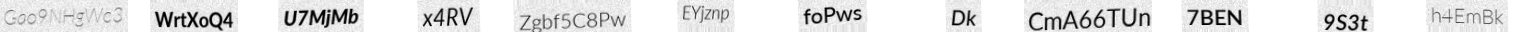

predictions ['', '', '', '', '', '', '', '', '', '', '', '']
500/500 [==============================] - 123s 246ms/step - loss: 27.2874 - accuracy: 0.0000e+00
Epoch 3/20
500/500 [==============================] - ETA: 0s - loss: 27.2365 - accuracy: 0.0000e+00

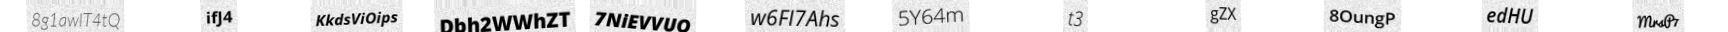

predictions ['', '', '', '', '', '', '', '', '', '', '', '']
500/500 [==============================] - 141s 281ms/step - loss: 27.2365 - accuracy: 0.0000e+00
Epoch 4/20
500/500 [==============================] - ETA: 0s - loss: 27.0000 - accuracy: 0.0000e+00

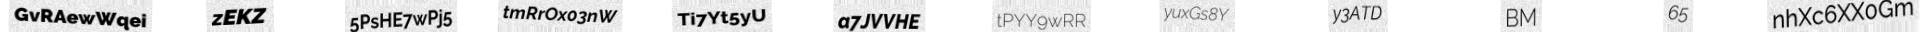

predictions ['', '', '', '', '', '', '', '', '', '', '', '']
500/500 [==============================] - 126s 253ms/step - loss: 27.0000 - accuracy: 0.0000e+00
Epoch 5/20
500/500 [==============================] - ETA: 0s - loss: 26.5031 - accuracy: 0.0000e+00

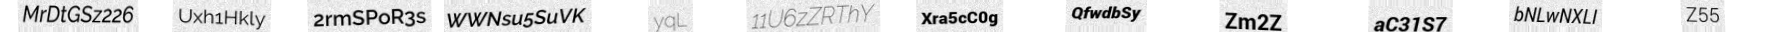

predictions ['', 'y', 'w', '', 'Z', '7', 'y', 'Z', 'T', 'Z', 'Z', 'j']
500/500 [==============================] - 111s 222ms/step - loss: 26.5031 - accuracy: 0.0000e+00
Epoch 6/20
500/500 [==============================] - ETA: 0s - loss: 25.6112 - accuracy: 0.0000e+00

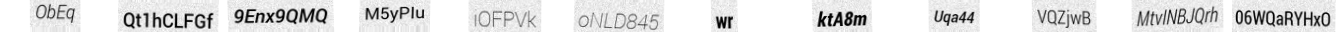

predictions ['j', '', '', 'o', 'o', '', 'd', 'm', 'j', 'o', '', '']
500/500 [==============================] - 114s 229ms/step - loss: 25.6112 - accuracy: 0.0000e+00
Epoch 7/20
500/500 [==============================] - ETA: 0s - loss: 22.5920 - accuracy: 2.0146e-05

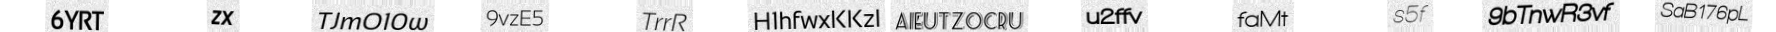

predictions ['6XT', 'ZI', '7OOm', '0vFI', 'TcT', 'Lb4wRRT', 'MRUTZOOWb', 'cZRo', 'kcbN', '6Ed', 'O6Zy', 'OwY9y']
500/500 [==============================] - 121s 241ms/step - loss: 22.5920 - accuracy: 2.0146e-05
Epoch 8/20
500/500 [==============================] - ETA: 0s - loss: 15.5492 - accuracy: 7.4540e-04- ETA: 9

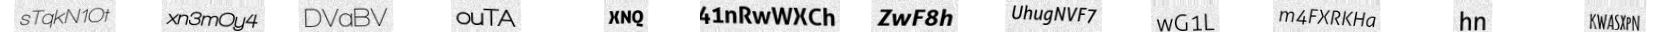

predictions ['oTqkNCy', 'xrmCW', 'PKoDW', 'OULA', 'WMC', '1nRmwWXc', 'ZxE5i', 'Uh49RVF7', 'w61T', 'mn4FXRMUw', 'h1', 'RqNgN']
500/500 [==============================] - 118s 236ms/step - loss: 15.5492 - accuracy: 7.4540e-04
Epoch 9/20
500/500 [==============================] - ETA: 0s - loss: 9.7796 - accuracy: 0.0015

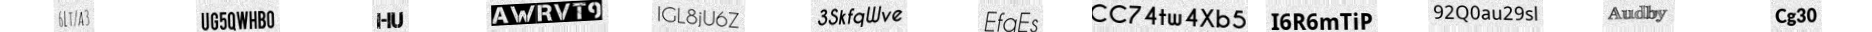

predictions ['tHJj', 'ig50jURS9', 'HU', 'UNRhWXU', 'lGLSiU6Z', '3SkfoUjve', 'EfoEs', 'CCZ4tw4Xb5', 'T6R6mTfP', '3ZQ0su29sI', 'Av4bz', 'Cs3Q']
500/500 [==============================] - 117s 235ms/step - loss: 9.7796 - accuracy: 0.0015
Epoch 10/20
500/500 [==============================] - ETA: 0s - loss: 6.5241 - accuracy: 0.0020 ETA: 0s - loss: 6.5158 - accuracy: 

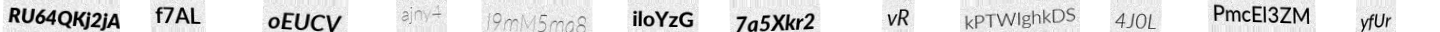

predictions ['RU64QKj2IA', 't7AL', 'oEUCV', '4jnd', 'I9mrNM5m43', 'ioYzG', '7a5Xkr2', 'vR', 'pWighkDS', '4J0L', 'PmcEl3ZM', 'yUr']
500/500 [==============================] - 119s 238ms/step - loss: 6.5241 - accuracy: 0.0020
Epoch 11/20
500/500 [==============================] - ETA: 0s - loss: 4.8971 - accuracy: 0.0024

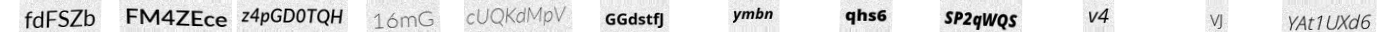

predictions ['fdFSZb', 'FM4ZEce', 'z4pGD0TQH', '16mG', 'cUQKdMpV', 'GGdstD', 'ymbn', 'qhs6', '5P2qWQs', 'v4', 'j', 'At1UXa6']
500/500 [==============================] - 115s 231ms/step - loss: 4.8971 - accuracy: 0.0024
Epoch 12/20
500/500 [==============================] - ETA: 0s - loss: 3.7253 - accuracy: 0.0023

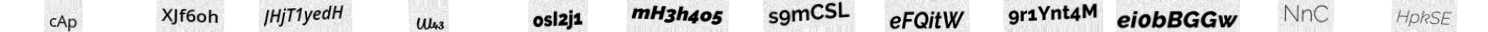

predictions ['cAp', 'XJf6oh', 'JHjT1yedH', 'WMq', 'osI2j1', 'mH3h4o5', 's9mCSL', 'eFQitW', 'gr1Ynt4M', 'eIobBGGw', 'NnG', 'HpkSE']
500/500 [==============================] - 116s 231ms/step - loss: 3.7253 - accuracy: 0.0023
Epoch 13/20
500/500 [==============================] - ETA: 0s - loss: 2.9953 - accuracy: 0.0025

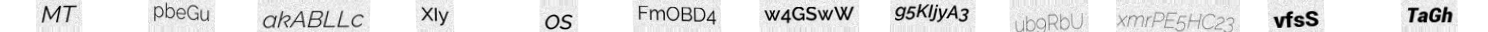

predictions ['MT', 'pbeGu', 'akABLLc', 'XIy', '0S', 'FmOBD4', 'w4GSwW', 'g5KlIjyA3', 'ubaRbU', 'xmrPE5HC23', 'vfsS', 'TaGh']
500/500 [==============================] - 117s 234ms/step - loss: 2.9953 - accuracy: 0.0025
Epoch 14/20
500/500 [==============================] - ETA: 0s - loss: 2.4962 - accuracy: 0.0025

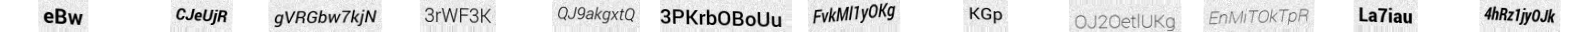

predictions ['eBw', 'CJeUjR', 'gVRGbw7kjN', '3rWF3K', 'QJ9akgxtQ', '3PKrbOBoUu', 'FuMI1yOKg', 'KGp', 'OJ2OetUKg', 'EnMiTOkTpR', 'La7iau', '4hRz1jGJk']
500/500 [==============================] - 113s 227ms/step - loss: 2.4962 - accuracy: 0.0025
Epoch 15/20
500/500 [==============================] - ETA: 0s - loss: 2.0758 - accuracy: 0.0026

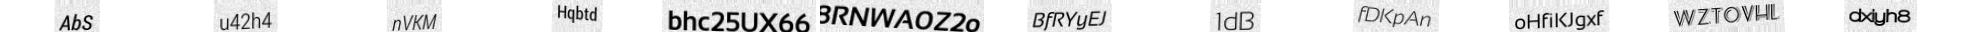

predictions ['AbS', 'u42h4', 'nVKM', 'Habtd', 'bhc25UX66', '8RNWA0Z2o', 'RfRYyEJ', '1dB', 'fDKpAn', 'oHfiKJgxf', 'wzt0VHL', 'cxlyh8']
500/500 [==============================] - 116s 231ms/step - loss: 2.0758 - accuracy: 0.0026
Epoch 16/20
500/500 [==============================] - ETA: 0s - loss: 1.7687 - accuracy: 0.0026

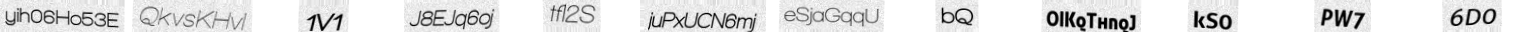

predictions ['yih06Ho53E', 'QkvsKHvl', '1V1', 'J8EJq6oy', 'tfl2S', 'juPxUCN6nj', 'eSaGqqU', 'bQ', 'OIKqThnoJ', 'kSo', 'PW7', '6D0']
500/500 [==============================] - 115s 229ms/step - loss: 1.7687 - accuracy: 0.0026
Epoch 17/20
500/500 [==============================] - ETA: 0s - loss: 1.7341 - accuracy: 0.0026

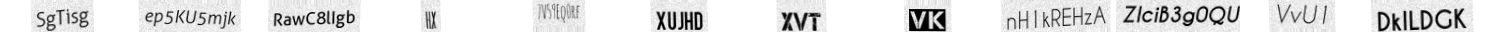

predictions ['SgTisB', 'ep5KU5mjk', 'RawC8lIgb', 'X', '7V37Eq7rf', 'xUjHD', 'XVT', 'K', 'nH1kREHzA', 'ZIciB3g0QU', 'VvU1', 'DkILDGK']
500/500 [==============================] - 114s 229ms/step - loss: 1.7341 - accuracy: 0.0026
Epoch 18/20
500/500 [==============================] - ETA: 0s - loss: 1.2427 - accuracy: 0.0027

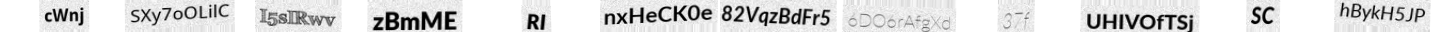

predictions ['cWnj', 'SXy7oOLilC', 'I5sIRwv', 'zBmME', 'RI', 'nxHeCK0e', '82VqzBdFr5', '6DO6rAfgXa', '37f', 'UHIVOfTSj', 'SC', 'hBykH5JP']
500/500 [==============================] - 116s 232ms/step - loss: 1.2427 - accuracy: 0.0027
Epoch 19/20
500/500 [==============================] - ETA: 0s - loss: 1.1405 - accuracy: 0.0027

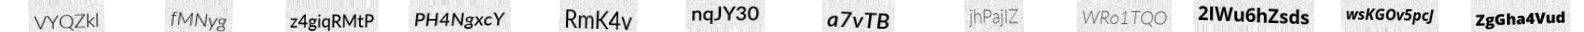

predictions ['VYQZkl', 'fMNyq', 'z4giqRMtP', 'PH4NgxcY', 'RmK4v', 'nqJY30', 'a7vTB', 'jhPajIZ', 'WRo1TQO', '2IWu6hZsds', 'wsKGOv5p9cJ', 'ZgGha4Vud']
500/500 [==============================] - 116s 231ms/step - loss: 1.1405 - accuracy: 0.0027
Epoch 20/20
500/500 [==============================] - ETA: 0s - loss: 1.0507 - accuracy: 0.0027

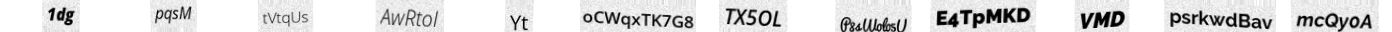

predictions ['1dg', 'pqsM', 'tVqUs', 'AwRtol', 'Yt', 'oCWqxTK7G8', 'TX5OL', 'P8sWo85U', 'E4TpMKD', 'VMD', 'psrkwdBav', 'mcQy0A']
500/500 [==============================] - 115s 230ms/step - loss: 1.0507 - accuracy: 0.0027


In [4]:
H = model.fit(datagen, epochs=20, verbose=1, callbacks=[predvis, model_saver])

model loaded


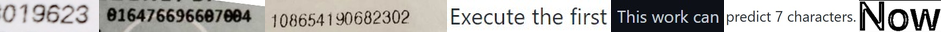

predictions ['O13623', '8164766966a7B8', '10865410682302', 'Executethefirst', 'hp5m894RG4m', 'prezdict7characiers', 'Dyn']
inference time with image loading, model loading, preprocessing etc: 0.2618706226348877


In [111]:
# do a test inference from the files in inference_test_imgs/
# why there are errors?
# - The model has been not trained on the domain, character size,
# character separation, margins, background
# overfitting to training data so use more regularization etc etc
start = time.time()
inference.inference_from_folder()
end = time.time()
print("inference time with image loading, model loading, preprocessing etc:", end - start)

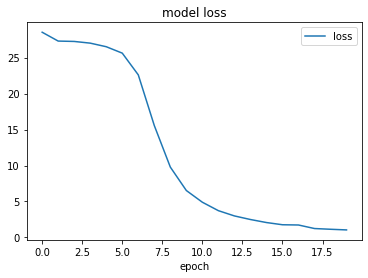

In [6]:
from matplotlib import pyplot
pyplot.plot(H.history['loss'])
pyplot.title('model loss')
pyplot.xlabel('epoch')
pyplot.legend(['loss'], loc='upper right')
pyplot.show() 

## Model 1

In [29]:
input_img = Input(name='the_input', shape=(None, img_h, 3))

# CNN block
x = Conv2D(8, 3, activation="relu", padding="same")(input_img)
x = Conv2D(16, 3, activation="relu", padding="same")(x)
x = MaxPooling2D()(x)

x = Conv2D(32, 3, activation="relu", padding="same")(x)
x = Conv2D(64, 3, activation="relu", padding="same")(x)
x = MaxPooling2D()(x)

# flatten the height and channels to one dimension, after this the dimension
# is batch, width, len(height)*len(channels)
tdist = TimeDistributed(Flatten(), name='timedistrib')(x)

# map to encoding dimension for rnn (or just next dense if rnn skipped):
rnn_in = Dense(128, activation="relu", name='dense_in')(tdist)


y_pred = Dense(num_chars+1, name="predictions", activation='softmax')(rnn_in)

#construct the model
model = Model(inputs=input_img, outputs=y_pred)


#********CALLBACKS AND LOSSES****************
# get the cool outputs
predvis = custom_callbacks.PredVisualize(model,val_datagen, lbl_to_char_dict, printing=True)
model_saver = custom_callbacks.make_save_model_cb()
custom_loss = losses.custom_ctc()

In [30]:
model.compile(loss=custom_loss, optimizer="Adam", metrics=['accuracy'])
tf.keras.models.save_model(model, "saved_models", overwrite=True, include_optimizer=False)

INFO:tensorflow:Assets written to: saved_models\assets


INFO:tensorflow:Assets written to: saved_models\assets


Epoch 1/20
500/500 [==============================] - ETA: 0s - loss: 27.7818 - accuracy: 0.0000e+00WARNING:tensorflow:5 out of the last 22 calls to <function Model.make_predict_function.<locals>.predict_function at 0x0000027E62711310> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has experimental_relax_shapes=True option that relaxes argument shapes that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/guide/function#controlling_retracing and https://www.tensorflow.org/api_docs/python/tf/function for  more details.


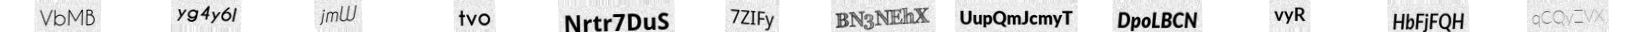

predictions ['', '', '', '', '', '', '', '', '', '', '', '']
500/500 [==============================] - 61s 119ms/step - loss: 27.7818 - accuracy: 0.0000e+00
Epoch 2/20
500/500 [==============================] - ETA: 0s - loss: 26.7297 - accuracy: 0.0000e+00WARNING:tensorflow:6 out of the last 23 calls to <function Model.make_predict_function.<locals>.predict_function at 0x0000027E62711310> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has experimental_relax_shapes=True option that relaxes argument shapes that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/guide/function#controlling_retracing and https://www.tensorflow.org/api_docs/python/tf/function for  more details.


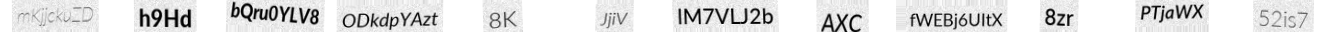

predictions ['', '', '', '', '', '', '', '', '', '', '', '']
500/500 [==============================] - 66s 131ms/step - loss: 26.7297 - accuracy: 0.0000e+00
Epoch 3/20
500/500 [==============================] - ETA: 0s - loss: 23.4881 - accuracy: 3.5906e-04

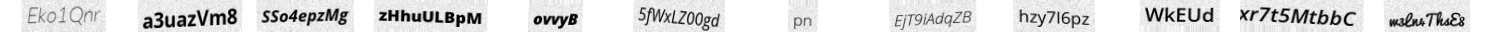

predictions ['So4Qn', '5uuozWnB', '654opss', 'nuuu5pnn', 'on6', '6WKnsd', 'pn', 'eAdnz6', 'h76z', 'WKSUd', '7b5tbC', 'w9w7Ru']
500/500 [==============================] - 63s 126ms/step - loss: 23.4881 - accuracy: 3.5906e-04
Epoch 4/20
500/500 [==============================] - ETA: 0s - loss: 10.7761 - accuracy: 0.0032

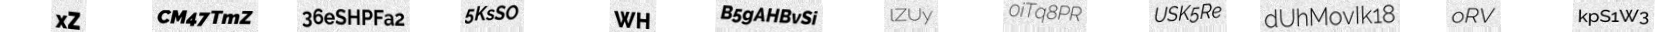

predictions ['xZ', 'CN47Tmmz', '36eSHpFa2', '5KsS9', 'wWH', 'BSgABSi', 'zUKY', 'OTqBPR', 'SK5SRG', 'dUhMNDlK18', 'oR', 'kPst3']
500/500 [==============================] - 61s 123ms/step - loss: 10.7761 - accuracy: 0.0032
Epoch 5/20
500/500 [==============================] - ETA: 0s - loss: 7.0091 - accuracy: 0.0033

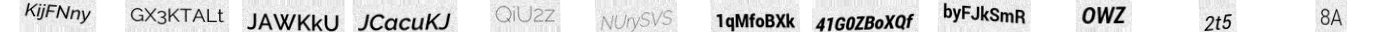

predictions ['KJFNy', 'GX3KTALt', 'JAwKkJ', 'JCdcuKU', 'QJ2z', 'MUr5S', '1qMMifoBXk', '41G0ZBbXQf', 'byFUkSmR', '0Z', '2t5', '8A']
500/500 [==============================] - 60s 120ms/step - loss: 7.0091 - accuracy: 0.0033
Epoch 6/20
500/500 [==============================] - ETA: 0s - loss: 5.6237 - accuracy: 0.0035

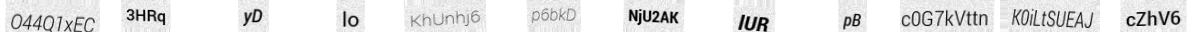

predictions ['044Q1TxED', '3HRq', 'yD', 'Ilo', 'khynhj5', 'p6bkD9', 'Mju2Ak', 'JUR', 'pB', 'c0G7ktn', 'K0LtSJEAJ', 'cZhV6']
500/500 [==============================] - 59s 118ms/step - loss: 5.6237 - accuracy: 0.0035
Epoch 7/20
500/500 [==============================] - ETA: 0s - loss: 4.8373 - accuracy: 0.0034

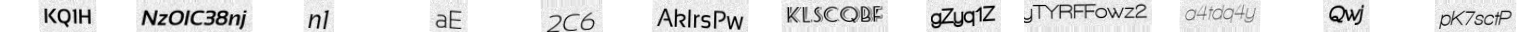

predictions ['IKQH', 'NzOIC3Bnji', 'n1', 'aE', '2ZC6', 'AkIrsPW', 'kLSCQbF', 'gZyq1Z', 'yTRFFoz', 'aH4tdqH4', 'QwJj', 'pK7sciP']
500/500 [==============================] - 60s 119ms/step - loss: 4.8373 - accuracy: 0.0034
Epoch 8/20
500/500 [==============================] - ETA: 0s - loss: 4.2265 - accuracy: 0.0035

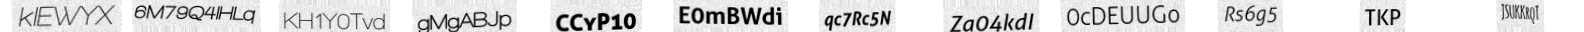

predictions ['klEWYX', '6M79Q4HLq', 'KH1YOTvd', 'gAgABUp', 'CCyP1O', 'E0mnBVWdi', 'qc7Rc5M', 'ZaO4kdI', '0COEUUG0', 'RSs6g5', 'TKP', 'iiKi']
500/500 [==============================] - 66s 131ms/step - loss: 4.2265 - accuracy: 0.0035
Epoch 9/20
500/500 [==============================] - ETA: 0s - loss: 3.7727 - accuracy: 0.0034

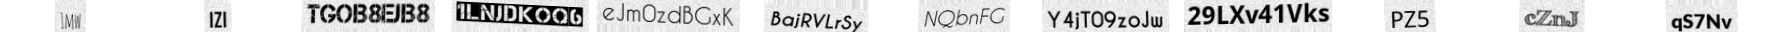

predictions ['iM4', 'lZI', 'TGBEJBB', 'oB', 'eJmzdBCxK', 'BajRVLrSy', 'NQbnFG', 'Y4jT09zoJw', '29LX41kS', 'PZ5', 'cZznLG', 'qS7Nv']
500/500 [==============================] - 65s 130ms/step - loss: 3.7727 - accuracy: 0.0034
Epoch 10/20
500/500 [==============================] - ETA: 0s - loss: 3.4745 - accuracy: 0.0034

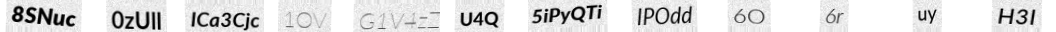

predictions ['8SNuc', '0zUl', 'ICa3Cjc', '1OV', 'G14zZ', 'U4Q', '5iPyQTi', 'lPOdd', '6O', '6r', 'uy', 'H3I']
500/500 [==============================] - 61s 123ms/step - loss: 3.4745 - accuracy: 0.0034
Epoch 11/20
500/500 [==============================] - ETA: 0s - loss: 3.2091 - accuracy: 0.0036

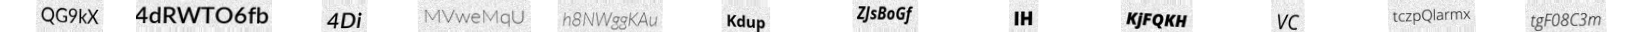

predictions ['QG9kX', '4dRVWTO6fb', '4Dij', 'MvweNqU', 'h8NVWggKAu', 'Kdup', 'ZJsBoGf', 'IH', 'KjFQKh', 'VC', 'tzpQarmx', 'tgF08C3m']
500/500 [==============================] - 60s 120ms/step - loss: 3.2091 - accuracy: 0.0036
Epoch 12/20
500/500 [==============================] - ETA: 0s - loss: 2.9761 - accuracy: 0.0036

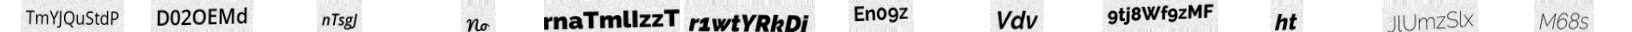

predictions ['tmYjJQuStdP', 'D020EMd', 'nTsgJ', 'de', 'xmaTTmnlIzzT', 'r1wtYRhDf', 'En09z', 'dv', '9tj8wf9zMF', 'hnt', 'UIUrmzSx', 'N68s']
500/500 [==============================] - 59s 119ms/step - loss: 2.9761 - accuracy: 0.0036
Epoch 13/20
500/500 [==============================] - ETA: 0s - loss: 2.8361 - accuracy: 0.0036

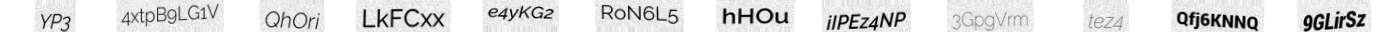

predictions ['YP3', '4xtpB9LG1V', 'QhOri', 'LkFCXX', 'e4yKG2', 'RoN6L5', 'hHOu', 'iIPEz4NP', '3GpcgVrm', 'tez4', 'Qfj6KNNQ', '9GLirSz']
500/500 [==============================] - 58s 116ms/step - loss: 2.8361 - accuracy: 0.0036
Epoch 14/20
500/500 [==============================] - ETA: 0s - loss: 2.6272 - accuracy: 0.0036

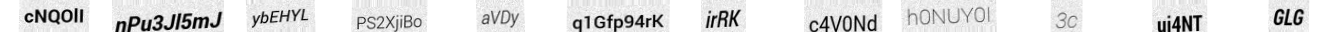

predictions ['cNQ0lI', 'nPu3Jl5mJ', 'ybEHYL', 'PS2XjiBo', 'aVDy', 'q1Gfp94rK', 'irRK', 'c4V0Nd', 'h0NUY0l', '3C', 'ui4Ni', 'GLgG']
500/500 [==============================] - 70s 140ms/step - loss: 2.6272 - accuracy: 0.0036
Epoch 15/20
500/500 [==============================] - ETA: 0s - loss: 2.4719 - accuracy: 0.0037

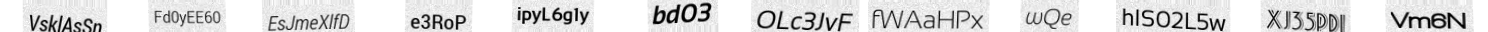

predictions ['VskI4sSo', 'Fd0yEE60', 'EsJmexIfD', 'e3RoP', 'ipyL6gIy', 'bd3', 'OLc3Jv', 'fWAaHPx', 'wQe', 'hISO2L5Sw', 'XJI35PDI', 'nS']
500/500 [==============================] - 60s 119ms/step - loss: 2.4719 - accuracy: 0.0037
Epoch 16/20
500/500 [==============================] - ETA: 0s - loss: 2.3614 - accuracy: 0.0036

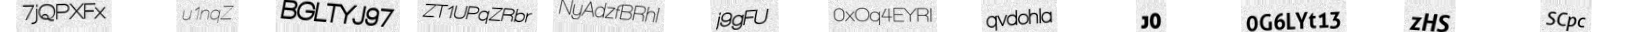

predictions ['7jQPXFX', 'u1nqZ', 'P8SLTYJ97', 'ZT1UPqZRbr', 'UAdzfBRhl', 'j9gFU', '0xOq4YRl', 'qvdoh', 'j0', '0G6LYt13', 'zHS', 'SCpc']
500/500 [==============================] - 62s 124ms/step - loss: 2.3614 - accuracy: 0.0036
Epoch 17/20
500/500 [==============================] - ETA: 0s - loss: 2.1955 - accuracy: 0.0037

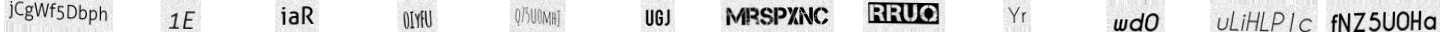

predictions ['Jcgwf5Dbph', '1E', 'iaR', '0cIyFV', 'qU70mhi', 'u8J', 'MrsPxNC', '3pUQ', 'Yr', 'wdO', 'uLiHLP1c', 'fMZ5U0Ha']
500/500 [==============================] - 64s 127ms/step - loss: 2.1955 - accuracy: 0.0037
Epoch 18/20
500/500 [==============================] - ETA: 0s - loss: 2.1682 - accuracy: 0.0038

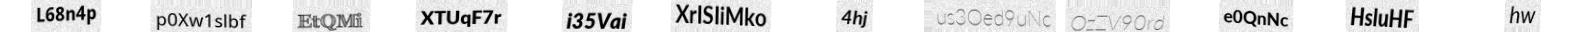

predictions ['L68n4p', 'p0Xw1sIbf', 'tQMi', 'XTUqF7r', 'i35Vai', 'XrIlSIiMk0', '4hj', 'u3Oed9uN', 'OzZv90rd', 'e0QnNc', 'HslIuHF', 'hW']
500/500 [==============================] - 63s 126ms/step - loss: 2.1682 - accuracy: 0.0038
Epoch 19/20
500/500 [==============================] - ETA: 0s - loss: 2.0936 - accuracy: 0.0036

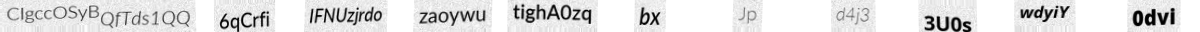

predictions ['CIgccOSyB', 'QfTds1QQ', '6qCrfi', 'IFNUzjrdo', 'zaOywu', 'tighA0zq', 'bX', 'Jp', 'd4j3', '3U0s', 'wdyiY', '0dvi']
500/500 [==============================] - 60s 119ms/step - loss: 2.0936 - accuracy: 0.0036
Epoch 20/20
500/500 [==============================] - ETA: 0s - loss: 1.9852 - accuracy: 0.0036

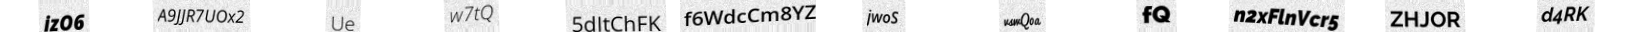

predictions ['iz06', 'A9JR7Uox2', 'Ue', 'w7tQ', '5dtChFK', 'f6wdcCm8YZ', 'jwoS', 'vswQa', 'fQ', 'n2xFlnVecr5', 'ZHJOR', 'd4RK']
500/500 [==============================] - 59s 118ms/step - loss: 1.9852 - accuracy: 0.0036


In [31]:
H = model.fit(datagen, epochs=20, verbose=1, callbacks=[predvis, model_saver])

# Image Preprocessing and Predictions

In [10]:
pytesseract.pytesseract.tesseract_cmd = 'C:\\Program Files\\Tesseract-OCR\\tesseract.exe'

def get_predictions_from_image(img_loc='4.png'):
    # Read the image
    img = cv2.imread(img_loc,0)
    
    # Apply image thresholding
#     img = cv2.adaptiveThreshold(img, 255,cv2.ADAPTIVE_THRESH_GAUSSIAN_C,cv2.THRESH_BINARY,11,2)
    img = cv2.adaptiveThreshold(img, 255,cv2.THRESH_BINARY,cv2.THRESH_BINARY,11,2)
    
    # Invert the image, 255 is the maximum value
    # img = 255 - img_thresh

    # Detecting Words
    kernel = np.ones((2,2),np.uint8)
    words_pics = []
    hImg, wImg = img.shape
    boxes = pytesseract.image_to_data(img)
    img_num = 1
    predictions = []
    for x,b in enumerate(boxes.splitlines()):
        if x != 0:
            b = b.split()
            if len(b) == 12:
                x,y,w,h = int(b[6]),int(b[7]),int(b[8]),int(b[9])
                words_pics.append(img[y-2:y+h+2,x-2:w+x+2])
                ###################################################################################################
                # Now predict the original image
                im.fromarray(img[y-2:y+h+2,x-2:w+x+2]).convert('RGB').save(f'inference_test_imgs\\{img_num}.jpg','JPEG')
                print(inference.inference_from_folder())
                ###################################################################################################
                # Now predict the original image (lower res.)
                sub_img = cv2.imread(f'inference_test_imgs\\{img_num}.jpg')
                sub_img = cv2.fastNlMeansDenoisingColored(sub_img, None, 10, 10, 7, 21)
                im.fromarray(sub_img).convert('RGB').save(f'inference_test_imgs\\{img_num+1}.jpg','JPEG')
                print(inference.inference_from_folder())
                ###################################################################################################
                # Thinning the new predict the original image (lower res.)
                sub_img1 = cv2.imread(f'inference_test_imgs\\{img_num+1}.jpg',0)
                sub_img1 = cv2.erode(sub_img1,kernel,iterations = 2)
                im.fromarray(sub_img1).convert('RGB').save(f'inference_test_imgs\\{img_num+2}.jpg','JPEG')
                print(inference.inference_from_folder())
                ###################################################################################################
                # Now predict the inverted image
                PIL.ImageOps.invert(
                    im.fromarray(img[y-2:y+h+2,x-2:w+x+2])
                ).convert('RGB').save(f'inference_test_imgs\\{img_num+3}.jpg','JPEG')
                print(inference.inference_from_folder())
                ###################################################################################################
                # Now predict the inverted image (lower res.)
                PIL.ImageOps.invert(
                    im.fromarray(sub_img)
                ).convert('RGB').save(f'inference_test_imgs\\{img_num+4}.jpg','JPEG')
                print(inference.inference_from_folder())
                ###################################################################################################
                # Now predict the inverted image (thinned the new predict the original image (lower res.))
                PIL.ImageOps.invert(
                    im.fromarray(sub_img1)
                ).convert('RGB').save(f'inference_test_imgs\\{img_num+5}.jpg','JPEG')
                print(inference.inference_from_folder())
                ###################################################################################################
                predictions.append(inference.inference_from_folder())
                # Let's delete the image
                os.remove(f'inference_test_imgs\\{img_num}.jpg')
                os.remove(f'inference_test_imgs\\{img_num+1}.jpg')
                os.remove(f'inference_test_imgs\\{img_num+2}.jpg')
                os.remove(f'inference_test_imgs\\{img_num+3}.jpg')
                os.remove(f'inference_test_imgs\\{img_num+4}.jpg')
                os.remove(f'inference_test_imgs\\{img_num+5}.jpg')

                img_num+=1
    return predictions            

model loaded
Instructions for updating:
Create a `tf.sparse.SparseTensor` and use `tf.sparse.to_dense` instead.


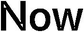

predictions ['Q']
['Q']
model loaded


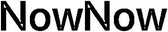

predictions ['Q', 'Q']
['Q', 'Q']
model loaded


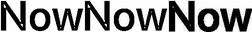

predictions ['Q', 'Q', 'QAf']
['Q', 'Q', 'QAf']
model loaded


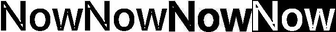

predictions ['Q', 'Q', 'QAf', 'Aaa']
['Q', 'Q', 'QAf', 'Aaa']
model loaded


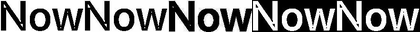

predictions ['Q', 'Q', 'QAf', 'Aaa', 'Aaa']
['Q', 'Q', 'QAf', 'Aaa', 'Aaa']
model loaded


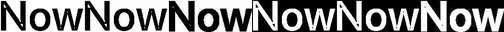

predictions ['Q', 'Q', 'QAf', 'Aaa', 'Aaa', 'Aa']
['Q', 'Q', 'QAf', 'Aaa', 'Aaa', 'Aa']
model loaded


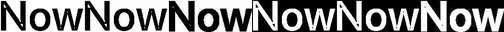

predictions ['Q', 'Q', 'QAf', 'Aaa', 'Aaa', 'Aa']
model loaded


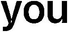

predictions ['j0']
['j0']
model loaded


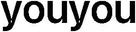

predictions ['j0', 'j0']
['j0', 'j0']
model loaded


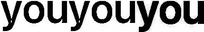

predictions ['j0', 'j0', 'Y0']
['j0', 'j0', 'Y0']
model loaded


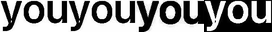

predictions ['j0', 'j0', 'Y0', 'H']
['j0', 'j0', 'Y0', 'H']
model loaded


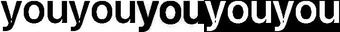

predictions ['j0', 'j0', 'Y0', 'H', 'H']
['j0', 'j0', 'Y0', 'H', 'H']
model loaded


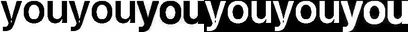

predictions ['j0', 'j0', 'Y0', 'H', 'H', 'dk']
['j0', 'j0', 'Y0', 'H', 'H', 'dk']
model loaded


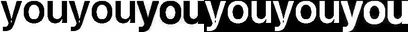

predictions ['j0', 'j0', 'Y0', 'H', 'H', 'dk']
model loaded


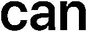

predictions ['mY']
['mY']
model loaded


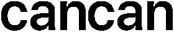

predictions ['mY', 'mY']
['mY', 'mY']
model loaded


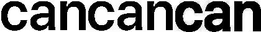

predictions ['mY', 'mY', 'Zmfl']
['mY', 'mY', 'Zmfl']
model loaded


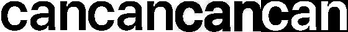

predictions ['mY', 'mY', 'Zmfl', 'Zd']
['mY', 'mY', 'Zmfl', 'Zd']
model loaded


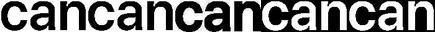

predictions ['mY', 'mY', 'Zmfl', 'Zd', 'Zd']
['mY', 'mY', 'Zmfl', 'Zd', 'Zd']
model loaded


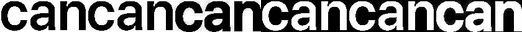

predictions ['mY', 'mY', 'Zmfl', 'Zd', 'Zd', 'ZlH']
['mY', 'mY', 'Zmfl', 'Zd', 'Zd', 'ZlH']
model loaded


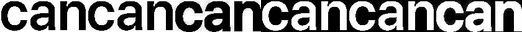

predictions ['mY', 'mY', 'Zmfl', 'Zd', 'Zd', 'ZlH']
model loaded


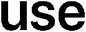

predictions ['kZQ']
['kZQ']
model loaded


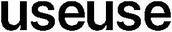

predictions ['kZQ', 'kZQ']
['kZQ', 'kZQ']
model loaded


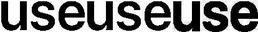

predictions ['kZQ', 'kZQ', 'SQ']
['kZQ', 'kZQ', 'SQ']
model loaded


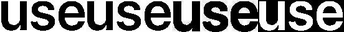

predictions ['kZQ', 'kZQ', 'SQ', 'Q']
['kZQ', 'kZQ', 'SQ', 'Q']
model loaded


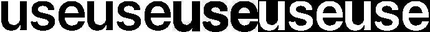

predictions ['kZQ', 'kZQ', 'SQ', 'Q', 'Q']
['kZQ', 'kZQ', 'SQ', 'Q', 'Q']
model loaded


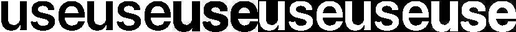

predictions ['kZQ', 'kZQ', 'SQ', 'Q', 'Q', 'Q']
['kZQ', 'kZQ', 'SQ', 'Q', 'Q', 'Q']
model loaded


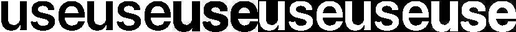

predictions ['kZQ', 'kZQ', 'SQ', 'Q', 'Q', 'Q']
model loaded


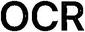

predictions ['QCK']
['QCK']
model loaded


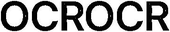

predictions ['QCK', 'QCK']
['QCK', 'QCK']
model loaded


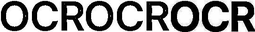

predictions ['QCK', 'QCK', 'QZS']
['QCK', 'QCK', 'QZS']
model loaded


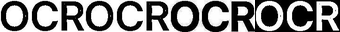

predictions ['QCK', 'QCK', 'QZS', 'a']
['QCK', 'QCK', 'QZS', 'a']
model loaded


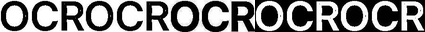

predictions ['QCK', 'QCK', 'QZS', 'a', 'a']
['QCK', 'QCK', 'QZS', 'a', 'a']
model loaded


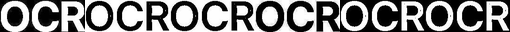

predictions ['d1S', 'QCK', 'QCK', 'QZS', 'a', 'a']
['d1S', 'QCK', 'QCK', 'QZS', 'a', 'a']
model loaded


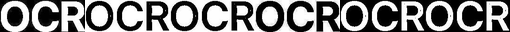

predictions ['d1S', 'QCK', 'QCK', 'QZS', 'a', 'a']
model loaded


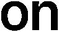

predictions ['1Y']
['1Y']
model loaded


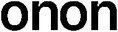

predictions ['1Y', '1Y']
['1Y', '1Y']
model loaded


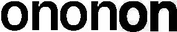

predictions ['1Y', '1Y', '1fl']
['1Y', '1Y', '1fl']
model loaded


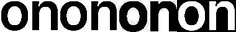

predictions ['1Y', '1Y', '1fl', 'Sd']
['1Y', '1Y', '1fl', 'Sd']
model loaded


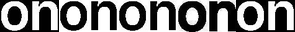

predictions ['Sd', '1Y', '1Y', '1fl', 'Sd']
['Sd', '1Y', '1Y', '1fl', 'Sd']
model loaded


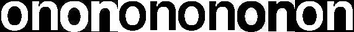

predictions ['Sd', '61H', '1Y', '1Y', '1fl', 'Sd']
['Sd', '61H', '1Y', '1Y', '1fl', 'Sd']
model loaded


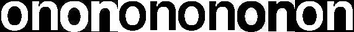

predictions ['Sd', '61H', '1Y', '1Y', '1fl', 'Sd']
model loaded


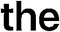

predictions ['t1g']
['t1g']
model loaded


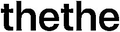

predictions ['t1g', 't1g']
['t1g', 't1g']
model loaded


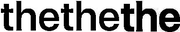

predictions ['t1g', 't1g', 'f1g']
['t1g', 't1g', 'f1g']
model loaded


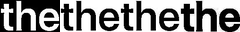

predictions ['1o', 't1g', 't1g', 'f1g']
['1o', 't1g', 't1g', 'f1g']
model loaded


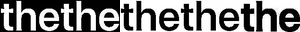

predictions ['1o', 'ao', 't1g', 't1g', 'f1g']
['1o', 'ao', 't1g', 't1g', 'f1g']
model loaded


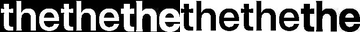

predictions ['1o', 'ao', '1G', 't1g', 't1g', 'f1g']
['1o', 'ao', '1G', 't1g', 't1g', 'f1g']
model loaded


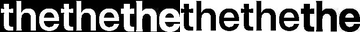

predictions ['1o', 'ao', '1G', 't1g', 't1g', 'f1g']
model loaded


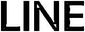

predictions ['klNC']
['klNC']
model loaded


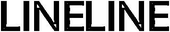

predictions ['klNC', 'klNC']
['klNC', 'klNC']
model loaded


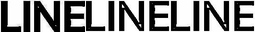

predictions ['kHNZ', 'klNC', 'klNC']
['kHNZ', 'klNC', 'klNC']
model loaded


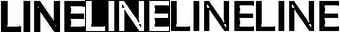

predictions ['kHNZ', 'alAZ', 'klNC', 'klNC']
['kHNZ', 'alAZ', 'klNC', 'klNC']
model loaded


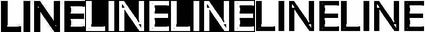

predictions ['kHNZ', 'alAZ', 'alAZ', 'klNC', 'klNC']
['kHNZ', 'alAZ', 'alAZ', 'klNC', 'klNC']
model loaded


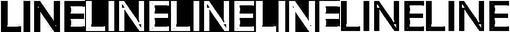

predictions ['kHNZ', 'alAZ', 'alAZ', 'JAlS', 'klNC', 'klNC']
['kHNZ', 'alAZ', 'alAZ', 'JAlS', 'klNC', 'klNC']
model loaded


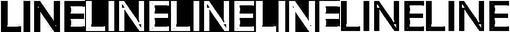

predictions ['kHNZ', 'alAZ', 'alAZ', 'JAlS', 'klNC', 'klNC']
model loaded


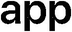

predictions ['SDO']
['SDO']
model loaded


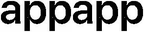

predictions ['SDO', 'SDO']
['SDO', 'SDO']
model loaded


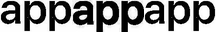

predictions ['SDO', 'S1o', 'SDO']
['SDO', 'S1o', 'SDO']
model loaded


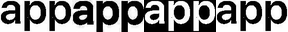

predictions ['SDO', 'S1o', 'Zlda', 'SDO']
['SDO', 'S1o', 'Zlda', 'SDO']
model loaded


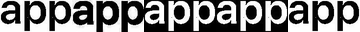

predictions ['SDO', 'S1o', 'Zlda', 'Zlda', 'SDO']
['SDO', 'S1o', 'Zlda', 'Zlda', 'SDO']
model loaded


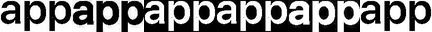

predictions ['SDO', 'S1o', 'Zlda', 'Zlda', 'Zo', 'SDO']
['SDO', 'S1o', 'Zlda', 'Zlda', 'Zo', 'SDO']
model loaded


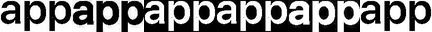

predictions ['SDO', 'S1o', 'Zlda', 'Zlda', 'Zo', 'SDO']
model loaded


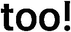

predictions ['t0a']
['t0a']
model loaded


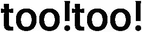

predictions ['t0a', 't0a']
['t0a', 't0a']
model loaded


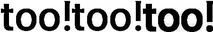

predictions ['t0a', 't0a', 'Q5']
['t0a', 't0a', 'Q5']
model loaded


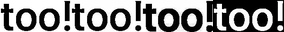

predictions ['t0a', 't0a', 'Q5', 'Qo']
['t0a', 't0a', 'Q5', 'Qo']
model loaded


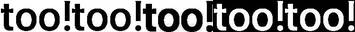

predictions ['t0a', 't0a', 'Q5', 'Qo', 'Qo']
['t0a', 't0a', 'Q5', 'Qo', 'Qo']
model loaded


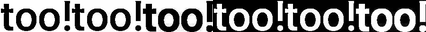

predictions ['t0a', 't0a', 'Q5', 'Qo', 'Qo', 'tZZ']
['t0a', 't0a', 'Q5', 'Qo', 'Qo', 'tZZ']
model loaded


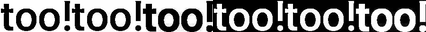

predictions ['t0a', 't0a', 'Q5', 'Qo', 'Qo', 'tZZ']
model loaded


predictions ['f']
['f']
model loaded


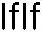

predictions ['f', 'f']
['f', 'f']
model loaded


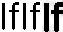

predictions ['f', 'f', 'f']
['f', 'f', 'f']
model loaded


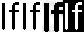

predictions ['f', 'f', 'f', 'q']
['f', 'f', 'f', 'q']
model loaded


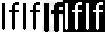

predictions ['f', 'f', 'f', 'q', 'q']
['f', 'f', 'f', 'q', 'q']
model loaded


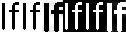

predictions ['f', 'f', 'f', 'q', 'q', 'ITT']
['f', 'f', 'f', 'q', 'q', 'ITT']
model loaded


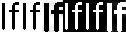

predictions ['f', 'f', 'f', 'q', 'q', 'ITT']
model loaded


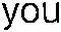

predictions ['YOU']
['YOU']
model loaded


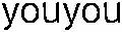

predictions ['YOU', 'YOU']
['YOU', 'YOU']
model loaded


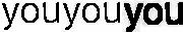

predictions ['YOU', 'YOU', '3Y0']
['YOU', 'YOU', '3Y0']
model loaded


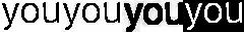

predictions ['YOU', 'YOU', '3Y0', 'dH']
['YOU', 'YOU', '3Y0', 'dH']
model loaded


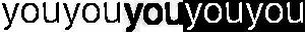

predictions ['YOU', 'YOU', '3Y0', 'dH', 'dH']
['YOU', 'YOU', '3Y0', 'dH', 'dH']
model loaded


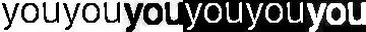

predictions ['YOU', 'YOU', '3Y0', 'dH', 'dH', 'fJl']
['YOU', 'YOU', '3Y0', 'dH', 'dH', 'fJl']
model loaded


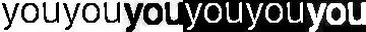

predictions ['YOU', 'YOU', '3Y0', 'dH', 'dH', 'fJl']
model loaded


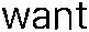

predictions ['Wmt']
['Wmt']
model loaded


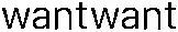

predictions ['Wmt', 'Wmi']
['Wmt', 'Wmi']
model loaded


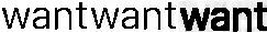

predictions ['Wmt', 'Wmi', 'Wdt']
['Wmt', 'Wmi', 'Wdt']
model loaded


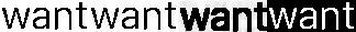

predictions ['Wmt', 'Wmi', 'Wdt', 'Aaq']
['Wmt', 'Wmi', 'Wdt', 'Aaq']
model loaded


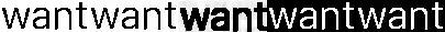

predictions ['Wmt', 'Wmi', 'Wdt', 'Aaq', 'Aaq']
['Wmt', 'Wmi', 'Wdt', 'Aaq', 'Aaq']
model loaded


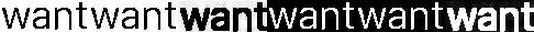

predictions ['Wmt', 'Wmi', 'Wdt', 'Aaq', 'Aaq', '1Z1d']
['Wmt', 'Wmi', 'Wdt', 'Aaq', 'Aaq', '1Z1d']
model loaded


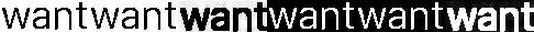

predictions ['Wmt', 'Wmi', 'Wdt', 'Aaq', 'Aaq', '1Z1d']
model loaded


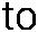

predictions ['tO']
['tO']
model loaded


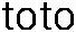

predictions ['tO', 'tO']
['tO', 'tO']
model loaded


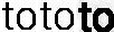

predictions ['tO', 'tO', 'tQ']
['tO', 'tO', 'tQ']
model loaded


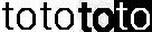

predictions ['tO', 'tO', 'tQ', 'q']
['tO', 'tO', 'tQ', 'q']
model loaded


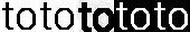

predictions ['tO', 'tO', 'tQ', 'q', 'q']
['tO', 'tO', 'tQ', 'q', 'q']
model loaded


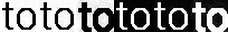

predictions ['tO', 'tO', 'tQ', 'q', 'q', 'o']
['tO', 'tO', 'tQ', 'q', 'q', 'o']
model loaded


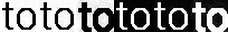

predictions ['tO', 'tO', 'tQ', 'q', 'q', 'o']
model loaded


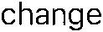

predictions ['ChahQg']
['ChahQg']
model loaded


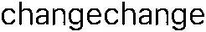

predictions ['ChahQg', 'ChahQg']
['ChahQg', 'ChahQg']
model loaded


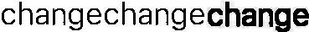

predictions ['ChahQg', 'ChahQg', 'GhGQg']
['ChahQg', 'ChahQg', 'GhGQg']
model loaded


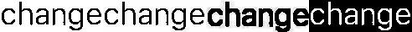

predictions ['ChahQg', 'ChahQg', 'GhGQg', 'qlco']
['ChahQg', 'ChahQg', 'GhGQg', 'qlco']
model loaded


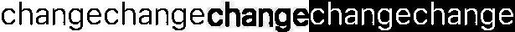

predictions ['ChahQg', 'ChahQg', 'GhGQg', 'qlco', 'qlco']
['ChahQg', 'ChahQg', 'GhGQg', 'qlco', 'qlco']
model loaded


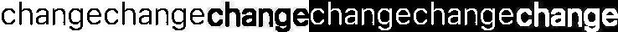

predictions ['ChahQg', 'ChahQg', 'GhGQg', 'qlco', 'qlco', 'xzQ']
['ChahQg', 'ChahQg', 'GhGQg', 'qlco', 'qlco', 'xzQ']
model loaded


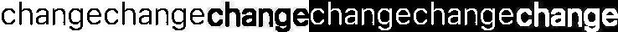

predictions ['ChahQg', 'ChahQg', 'GhGQg', 'qlco', 'qlco', 'xzQ']
model loaded


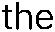

predictions ['t1G']
['t1G']
model loaded


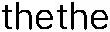

predictions ['t1G', 't1G']
['t1G', 't1G']
model loaded


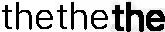

predictions ['t1G', 't1G', 'fDg']
['t1G', 't1G', 'fDg']
model loaded


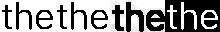

predictions ['t1G', 't1G', 'fDg', 'xo']
['t1G', 't1G', 'fDg', 'xo']
model loaded


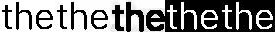

predictions ['t1G', 't1G', 'fDg', 'xo', 'xo']
['t1G', 't1G', 'fDg', 'xo', 'xo']
model loaded


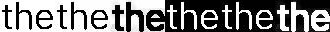

predictions ['t1G', 't1G', 'fDg', 'xo', 'xo', '11G']
['t1G', 't1G', 'fDg', 'xo', 'xo', '11G']
model loaded


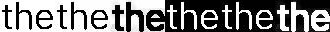

predictions ['t1G', 't1G', 'fDg', 'xo', 'xo', '11G']
model loaded


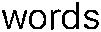

predictions ['WQfdS']
['WQfdS']
model loaded


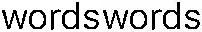

predictions ['WQfdS', 'WQTdS']
['WQfdS', 'WQTdS']
model loaded


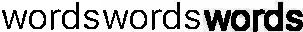

predictions ['WQfdS', 'WQTdS', 'WQdS']
['WQfdS', 'WQTdS', 'WQdS']
model loaded


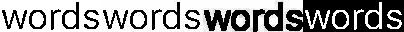

predictions ['WQfdS', 'WQTdS', 'WQdS', '6S']
['WQfdS', 'WQTdS', 'WQdS', '6S']
model loaded


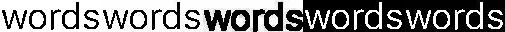

predictions ['WQfdS', 'WQTdS', 'WQdS', '6S', '6S']
['WQfdS', 'WQTdS', 'WQdS', '6S', '6S']
model loaded


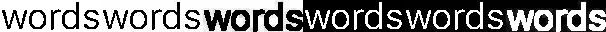

predictions ['WQfdS', 'WQTdS', 'WQdS', '6S', '6S', 'AAYJcQ']
['WQfdS', 'WQTdS', 'WQdS', '6S', '6S', 'AAYJcQ']
model loaded


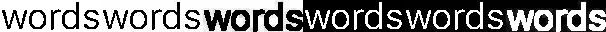

predictions ['WQfdS', 'WQTdS', 'WQdS', '6S', '6S', 'AAYJcQ']
model loaded


predictions ['iT']
['iT']
model loaded


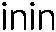

predictions ['iT', 'iT']
['iT', 'iT']
model loaded


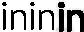

predictions ['iT', 'iT', 'ifT']
['iT', 'iT', 'ifT']
model loaded


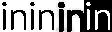

predictions ['iT', 'iT', 'ifT', 'n']
['iT', 'iT', 'ifT', 'n']
model loaded


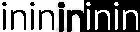

predictions ['iT', 'iT', 'ifT', 'n', 'n']
['iT', 'iT', 'ifT', 'n', 'n']
model loaded


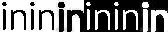

predictions ['iT', 'iT', 'ifT', 'n', 'n', 'TY']
['iT', 'iT', 'ifT', 'n', 'n', 'TY']
model loaded


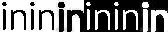

predictions ['iT', 'iT', 'ifT', 'n', 'n', 'TY']
model loaded


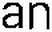

predictions ['1i']
['1i']
model loaded


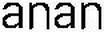

predictions ['1i', '1i']
['1i', '1i']
model loaded


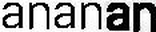

predictions ['1i', '1i', '1Y']
['1i', '1i', '1Y']
model loaded


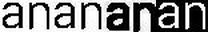

predictions ['1i', '1i', '1Y', 'ZdH']
['1i', '1i', '1Y', 'ZdH']
model loaded


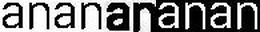

predictions ['1i', '1i', '1Y', 'ZdH', 'ZdH']
['1i', '1i', '1Y', 'ZdH', 'ZdH']
model loaded


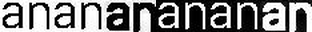

predictions ['1i', '1i', '1Y', 'ZdH', 'ZdH', 'Z18']
['1i', '1i', '1Y', 'ZdH', 'ZdH', 'Z18']
model loaded


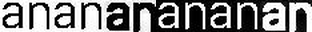

predictions ['1i', '1i', '1Y', 'ZdH', 'ZdH', 'Z18']
model loaded


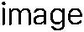

predictions ['IrigQg']
['IrigQg']
model loaded


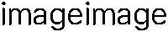

predictions ['IrigQg', 'IrigQg']
['IrigQg', 'IrigQg']
model loaded


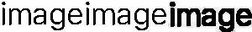

predictions ['IrigQg', 'IrigQg', 'iTeQg']
['IrigQg', 'IrigQg', 'iTeQg']
model loaded


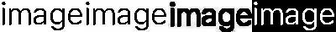

predictions ['IrigQg', 'IrigQg', 'iTeQg', 'co']
['IrigQg', 'IrigQg', 'iTeQg', 'co']
model loaded


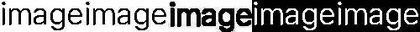

predictions ['IrigQg', 'IrigQg', 'iTeQg', 'co', 'co']
['IrigQg', 'IrigQg', 'iTeQg', 'co', 'co']
model loaded


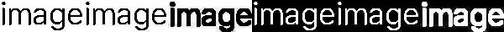

predictions ['IrigQg', 'IrigQg', 'iTeQg', 'co', 'co', 'Zo']
['IrigQg', 'IrigQg', 'iTeQg', 'co', 'co', 'Zo']
model loaded


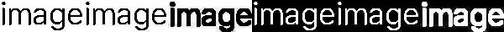

predictions ['IrigQg', 'IrigQg', 'iTeQg', 'co', 'co', 'Zo']
model loaded


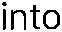

predictions ['i1t0']
['i1t0']
model loaded


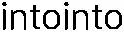

predictions ['i1t0', 'i1t0']
['i1t0', 'i1t0']
model loaded


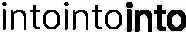

predictions ['i1t0', 'i1t0', 'iDo']
['i1t0', 'i1t0', 'iDo']
model loaded


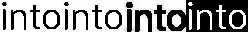

predictions ['i1t0', 'i1t0', 'iDo', 'TKq']
['i1t0', 'i1t0', 'iDo', 'TKq']
model loaded


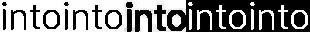

predictions ['i1t0', 'i1t0', 'iDo', 'TKq', 'TKq']
['i1t0', 'i1t0', 'iDo', 'TKq', 'TKq']
model loaded


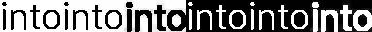

predictions ['i1t0', 'i1t0', 'iDo', 'TKq', 'TKq', 'iTTxzo']
['i1t0', 'i1t0', 'iDo', 'TKq', 'TKq', 'iTTxzo']
model loaded


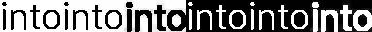

predictions ['i1t0', 'i1t0', 'iDo', 'TKq', 'TKq', 'iTTxzo']
model loaded


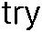

predictions ['tfV']
['tfV']
model loaded


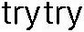

predictions ['tfV', 'tfV']
['tfV', 'tfV']
model loaded


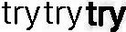

predictions ['tfV', 'tfV', 'tY']
['tfV', 'tfV', 'tY']
model loaded


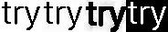

predictions ['tfV', 'tfV', 'tY', 'Y']
['tfV', 'tfV', 'tY', 'Y']
model loaded


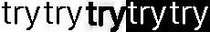

predictions ['tfV', 'tfV', 'tY', 'Y', 'Y']
['tfV', 'tfV', 'tY', 'Y', 'Y']
model loaded


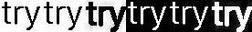

predictions ['tfV', 'tfV', 'tY', 'Y', 'Y', 'Y']
['tfV', 'tfV', 'tY', 'Y', 'Y', 'Y']
model loaded


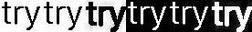

predictions ['tfV', 'tfV', 'tY', 'Y', 'Y', 'Y']
model loaded


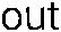

predictions ['0Ut']
['0Ut']
model loaded


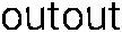

predictions ['0Ut', '0Ut']
['0Ut', '0Ut']
model loaded


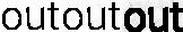

predictions ['0Ut', '0Ut', '18']
['0Ut', '0Ut', '18']
model loaded


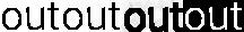

predictions ['0Ut', '0Ut', '18', 'x6d']
['0Ut', '0Ut', '18', 'x6d']
model loaded


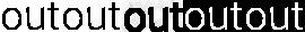

predictions ['0Ut', '0Ut', '18', 'x6d', 'x6d']
['0Ut', '0Ut', '18', 'x6d', 'x6d']
model loaded


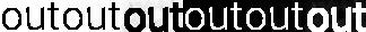

predictions ['0Ut', '0Ut', '18', 'x6d', 'x6d', '1td']
['0Ut', '0Ut', '18', 'x6d', 'x6d', '1td']
model loaded


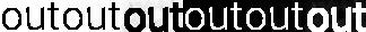

predictions ['0Ut', '0Ut', '18', 'x6d', 'x6d', '1td']
model loaded


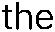

predictions ['t1G']
['t1G']
model loaded


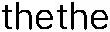

predictions ['t1G', 't1G']
['t1G', 't1G']
model loaded


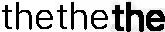

predictions ['t1G', 't1G', 'fDg']
['t1G', 't1G', 'fDg']
model loaded


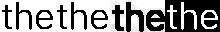

predictions ['t1G', 't1G', 'fDg', 'xo']
['t1G', 't1G', 'fDg', 'xo']
model loaded


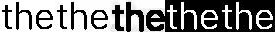

predictions ['t1G', 't1G', 'fDg', 'xo', 'xo']
['t1G', 't1G', 'fDg', 'xo', 'xo']
model loaded


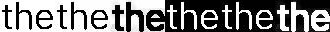

predictions ['t1G', 't1G', 'fDg', 'xo', 'xo', '11G']
['t1G', 't1G', 'fDg', 'xo', 'xo', '11G']
model loaded


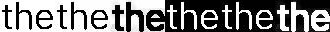

predictions ['t1G', 't1G', 'fDg', 'xo', 'xo', '11G']
model loaded


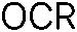

predictions ['1CR']
['1CR']
model loaded


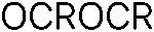

predictions ['1CR', '1CR']
['1CR', '1CR']
model loaded


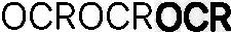

predictions ['1CR', '1CR', 'QS']
['1CR', '1CR', 'QS']
model loaded


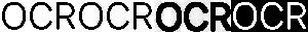

predictions ['1CR', '1CR', 'QS', 'gS']
['1CR', '1CR', 'QS', 'gS']
model loaded


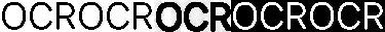

predictions ['1CR', '1CR', 'QS', 'gS', 'gS']
['1CR', '1CR', 'QS', 'gS', 'gS']
model loaded


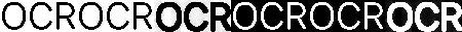

predictions ['1CR', '1CR', 'QS', 'gS', 'gS', 'ggZ']
['1CR', '1CR', 'QS', 'gS', 'gS', 'ggZ']
model loaded


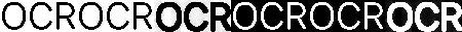

predictions ['1CR', '1CR', 'QS', 'gS', 'gS', 'ggZ']
model loaded


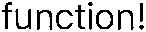

predictions ['fU1Ci0fJ']
['fU1Ci0fJ']
model loaded


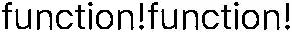

predictions ['fU1Ci0fJ', 'fU1Ci0fJ']
['fU1Ci0fJ', 'fU1Ci0fJ']
model loaded


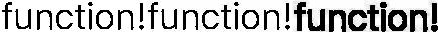

predictions ['fU1Ci0fJ', 'fU1Ci0fJ', 'UmttQ1a']
['fU1Ci0fJ', 'fU1Ci0fJ', 'UmttQ1a']
model loaded


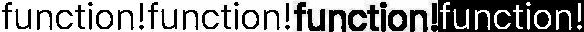

predictions ['fU1Ci0fJ', 'fU1Ci0fJ', 'UmttQ1a', 'GQo']
['fU1Ci0fJ', 'fU1Ci0fJ', 'UmttQ1a', 'GQo']
model loaded


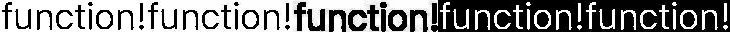

predictions ['fU1Ci0fJ', 'fU1Ci0fJ', 'UmttQ1a', 'GQo', 'GQo']
['fU1Ci0fJ', 'fU1Ci0fJ', 'UmttQ1a', 'GQo', 'GQo']
model loaded


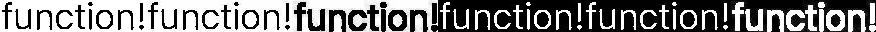

predictions ['fU1Ci0fJ', 'fU1Ci0fJ', 'UmttQ1a', 'GQo', 'GQo', 'aaH']
['fU1Ci0fJ', 'fU1Ci0fJ', 'UmttQ1a', 'GQo', 'GQo', 'aaH']
model loaded


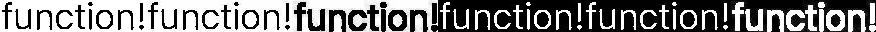

predictions ['fU1Ci0fJ', 'fU1Ci0fJ', 'UmttQ1a', 'GQo', 'GQo', 'aaH']


[['Q', 'Q', 'QAf', 'Aaa', 'Aaa', 'Aa'],
 ['j0', 'j0', 'Y0', 'H', 'H', 'dk'],
 ['mY', 'mY', 'Zmfl', 'Zd', 'Zd', 'ZlH'],
 ['kZQ', 'kZQ', 'SQ', 'Q', 'Q', 'Q'],
 ['d1S', 'QCK', 'QCK', 'QZS', 'a', 'a'],
 ['Sd', '61H', '1Y', '1Y', '1fl', 'Sd'],
 ['1o', 'ao', '1G', 't1g', 't1g', 'f1g'],
 ['kHNZ', 'alAZ', 'alAZ', 'JAlS', 'klNC', 'klNC'],
 ['SDO', 'S1o', 'Zlda', 'Zlda', 'Zo', 'SDO'],
 ['t0a', 't0a', 'Q5', 'Qo', 'Qo', 'tZZ'],
 ['f', 'f', 'f', 'q', 'q', 'ITT'],
 ['YOU', 'YOU', '3Y0', 'dH', 'dH', 'fJl'],
 ['Wmt', 'Wmi', 'Wdt', 'Aaq', 'Aaq', '1Z1d'],
 ['tO', 'tO', 'tQ', 'q', 'q', 'o'],
 ['ChahQg', 'ChahQg', 'GhGQg', 'qlco', 'qlco', 'xzQ'],
 ['t1G', 't1G', 'fDg', 'xo', 'xo', '11G'],
 ['WQfdS', 'WQTdS', 'WQdS', '6S', '6S', 'AAYJcQ'],
 ['iT', 'iT', 'ifT', 'n', 'n', 'TY'],
 ['1i', '1i', '1Y', 'ZdH', 'ZdH', 'Z18'],
 ['IrigQg', 'IrigQg', 'iTeQg', 'co', 'co', 'Zo'],
 ['i1t0', 'i1t0', 'iDo', 'TKq', 'TKq', 'iTTxzo'],
 ['tfV', 'tfV', 'tY', 'Y', 'Y', 'Y'],
 ['0Ut', '0Ut', '18', 'x6d', 'x6d', '1td'],
 ['t1G', 

In [11]:
get_predictions_from_image()

# Text Prediction

In [12]:
get_images_from_twitter(username = 'DunkinDonutsKSA', search = ['عرض'])

1461665593887801346 2021-11-19 15:00:08 +0300 <DunkinDonutsKSA> العرض اللي يسعدك طول اليوم .. عرض البيقل مع القهوة 🧡  https://t.co/nOLLZ9nQyk
1461341120756019204 2021-11-18 17:30:48 +0300 <DunkinDonutsKSA> يحبكم وتحبونه وفي كل ويك اند تلاقونه؟  عرض الجمعات 🤩🧡  https://t.co/DDVVw7b0Kt
1460959693409562637 2021-11-17 16:15:08 +0300 <DunkinDonutsKSA> عرض التوست من دانكن صديقك طول اليوم  🥳🧡  https://t.co/rIVpSrnj4R
1457630176926486528 2021-11-08 11:44:50 +0300 <DunkinDonutsKSA> قهوة سوداء بحجم كبير ..   مع عرض البيقل الخطير 🥳🧡  https://t.co/eyaIlWUvrO
1455546733002428422 2021-11-02 17:45:58 +0300 <DunkinDonutsKSA> يومك الحلو يكمل مع عرض التوست والقهوة من دانكن 🤩🧡 #موسم_الرياض  https://t.co/03UnbyHwnD
1453231625983123466 2021-10-27 08:26:34 +0300 <DunkinDonutsKSA> الواقع خيال اكثر مع عرض البيقل والقهوة 🥳  #موسم_الرياض #تخيل_اكثر 🤩🧡  https://t.co/iEJJc0lNGN
1452509323503022081 2021-10-25 08:36:23 +0300 <DunkinDonutsKSA> أفضل طريقة تبدأ فيها يومك هي عرض القهوة مع التوست من دانكن 🥳  https://t.c

In [13]:
texts = []
for i in range(3):
    texts.append(get_predictions_from_image(img_loc=f'scraped_imgs\\{i}.jpg'))

# Other Work

We'll use arabic letter detector

In [11]:
# list of all characters
# map each color to an integer, a "label" and reverse mapping
all_chars = "0123456789ضصثقفغعهخحجدطكمنتاألبيسشئءؤرلاىآةوزظذهإھچ'َ "
num_chars = len(all_chars)
char_to_lbl_dict = dict((char, ind) for ind, char in enumerate(all_chars))
lbl_to_char_dict = dict((ind, char) for ind, char in enumerate(all_chars))


# ************** DATA GENERATORS *********************
#use trdg for the base generator of text
# base_generator = GeneratorFromStrings(['Test1', 'Test2', 'Test3'],background_type=1, word_split=True, random_blur=True,
#                                      text_color='#000000')#, text_color=['#FFFFFF','#ff0000','#000000','#0000FF','#00FF00'])
base_generator = GeneratorFromDict(background_type=1, word_split=True, random_blur=True,
                                     length=3 , text_color='#000000', language='ar')
#add some more augmentation with keras ImageDataGenerator
keras_augm = ImageDataGenerator(rotation_range=2.0, width_shift_range=5.0, height_shift_range=5.0,
                                shear_range=4.0, zoom_range=0.1)

#the actual datagenerator for training and visualizations (and validation)
dg_params = {"batch_size": batch_size,"img_h": img_h, "keras_augmentor": keras_augm,
             "char_to_lbl_dict": char_to_lbl_dict}

datagen = batch_functions.OCR_generator(base_generator, **dg_params)
val_datagen = batch_functions.OCR_generator(base_generator, **dg_params, validation=True)


"""CNN downsampling block and flattening to time distributed layer from
the original image of shape (width, height, 3) will be mapped to (width/4, 128)"""

input_img = Input(name='the_input', shape=(None, img_h, 3))

# CNN block
x = Conv2D(8, 3, activation="relu", padding="same")(input_img)
x = Conv2D(16, 3, activation="relu", padding="same")(x)
x = MaxPooling2D()(x)

x = Conv2D(32, 3, activation="relu", padding="same")(x)
x = Conv2D(64, 3, activation="relu", padding="same")(x)
x = MaxPooling2D()(x)

# flatten the height and channels to one dimension, after this the dimension
# is batch, width, len(height)*len(channels)
tdist = TimeDistributed(Flatten(), name='timedistrib')(x)

# map to encoding dimension for rnn (or just next dense if rnn skipped):
# rnn_in = Dense(128, activation="relu", name='dense_in')(tdist)

# """run the inputs through lstm blocks"""

# lstm encoding layers
x = Bidirectional(LSTM(128, return_sequences=True))(tdist)
x = Bidirectional(LSTM(64, return_sequences=True))(x)
x = Bidirectional(LSTM(64, return_sequences=True))(x)

y_pred = Dense(num_chars+1, name="predictions", activation='softmax')(x)

#construct the model
model = Model(inputs=input_img, outputs=y_pred)


#********CALLBACKS AND LOSSES****************
# get the cool outputs
predvis = custom_callbacks.PredVisualize(model,val_datagen, lbl_to_char_dict, printing=True)
model_saver = custom_callbacks.make_save_model_cb()
custom_loss = losses.custom_ctc()


In [12]:
model.compile(loss=custom_loss, optimizer="Adam", metrics=['accuracy'])
tf.keras.models.save_model(model, "saved_models", overwrite=True, include_optimizer=False)

INFO:tensorflow:Assets written to: saved_models\assets


INFO:tensorflow:Assets written to: saved_models\assets


Epoch 1/20
500/500 [==============================] - ETA: 0s - loss: 70.6574 - accuracy: 5.4366e-04

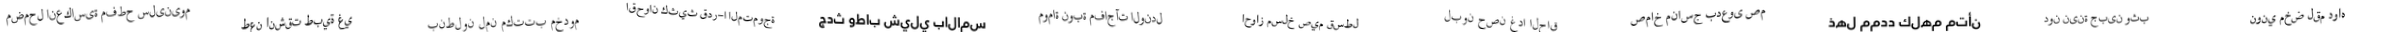

predictions ['ااة', 'ااة', 'ااة', 'ااة', 'ااة', 'ااة', 'ااة', 'ااة', 'ااة', 'ااة', 'ااة', 'ااة']
500/500 [==============================] - 231s 446ms/step - loss: 70.6574 - accuracy: 5.4366e-04
Epoch 2/20
500/500 [==============================] - ETA: 0s - loss: 69.1429 - accuracy: 0.0000e+00

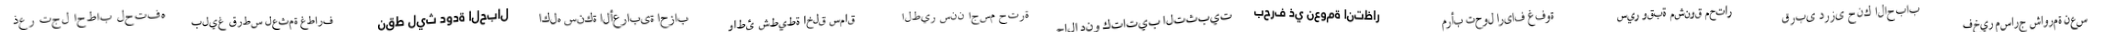

predictions ['الاة', 'الاة', 'الاة', 'الاة', 'الاة', 'الاة', 'الاة', 'الاة', 'الاة', 'الاة', 'الاة', 'الاة']
500/500 [==============================] - 219s 438ms/step - loss: 69.1429 - accuracy: 0.0000e+00
Epoch 3/20
500/500 [==============================] - ETA: 0s - loss: 68.4674 - accuracy: 0.0000e+00

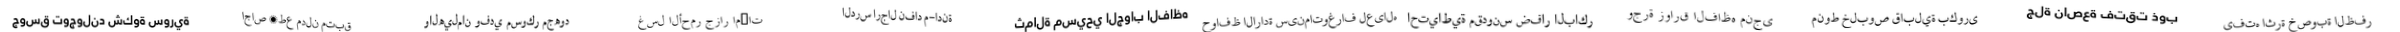

predictions ['الا اة', 'الا اة', 'الا اة', 'الا اة', 'الا اة', 'الا اة', 'الا اة', 'الا اة', 'الا اة', 'الا اة', 'الا اة', 'الا اة']
500/500 [==============================] - 239s 477ms/step - loss: 68.4674 - accuracy: 0.0000e+00
Epoch 4/20
500/500 [==============================] - ETA: 0s - loss: 66.5231 - accuracy: 0.0000e+00

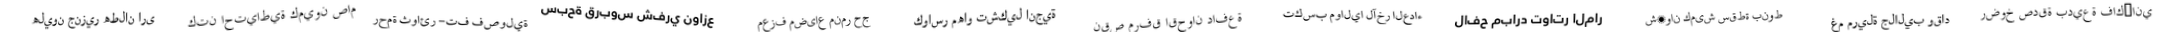

predictions ['ال   ة', 'ال   ة', 'ال   ة', 'ال   ة', 'ال   ة', 'ال   ة', 'ال   ة', 'ال   ة', 'ال   ة', 'ال   ة', 'ال   ة', 'ال   ة']
500/500 [==============================] - 228s 455ms/step - loss: 66.5231 - accuracy: 0.0000e+00
Epoch 5/20
500/500 [==============================] - ETA: 0s - loss: 63.7373 - accuracy: 0.0000e+00

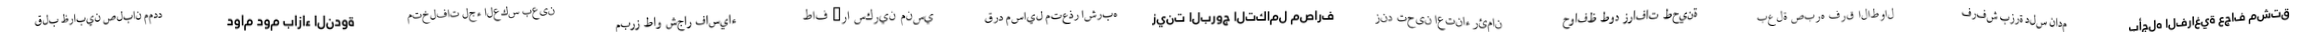

predictions ['ال  ا ة', 'ال  ا ة', 'ال  ا ة', 'ال  ا ة', 'ال  ا ة', 'ال  ا ة', 'ال  ا ة', 'ال  ا ة', 'ال  ا ة', 'ال  ا ة', 'ال  ا ة', 'ال  ا ة']
500/500 [==============================] - 256s 511ms/step - loss: 63.7373 - accuracy: 0.0000e+00
Epoch 6/20
500/500 [==============================] - ETA: 0s - loss: 62.8475 - accuracy: 0.0000e+00

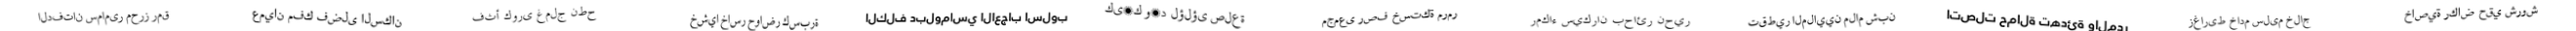

predictions ['ا ة اة ة', 'ا ة اة ة', 'ا ة اة ة', 'ا ة اة ة', 'ا ة اة ة', 'ا ة اة ة', 'ا ة اة ة', 'ا ة اة ة', 'ا ة اة ة', 'ا ة اة ة', 'ا ة اة ة', 'ا ة اة ة']
500/500 [==============================] - 272s 545ms/step - loss: 62.8475 - accuracy: 0.0000e+00
Epoch 7/20
500/500 [==============================] - ETA: 0s - loss: 62.5656 - accuracy: 0.0000e+00

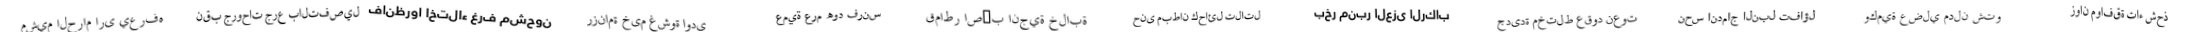

predictions ['ل ار اة اة', 'ل ار اة اة', 'ل ار اة اة', 'ل ار اة اة', 'ل ار اة اة', 'ل ار اة اة', 'ل ار اة اة', 'ل ار اة اة', 'ل ار اة اة', 'ل ار اة اة', 'ل ار اة اة', 'ل ار اة اة']
500/500 [==============================] - 286s 572ms/step - loss: 62.5656 - accuracy: 0.0000e+00
Epoch 8/20
500/500 [==============================] - ETA: 0s - loss: 62.4483 - accuracy: 0.0000e+00

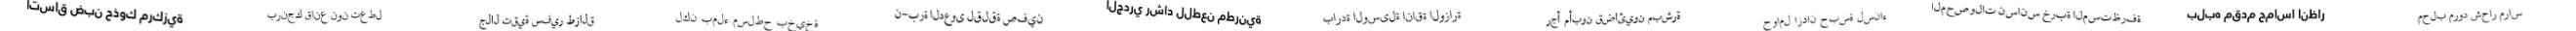

predictions ['ل ار ار اة', 'ل ار ار اة', 'ل ار ار اة', 'ل ار ار اة', 'ل ار ار اة', 'ل ار ار اة', 'ل ار ار اة', 'ل ار ار اة', 'ل ار ار اة', 'ل ار ار اة', 'ل ار ار اة', 'ل ار ار اة']
500/500 [==============================] - 267s 533ms/step - loss: 62.4483 - accuracy: 0.0000e+00
Epoch 9/20
500/500 [==============================] - ETA: 0s - loss: 62.2650 - accuracy: 0.0000e+00

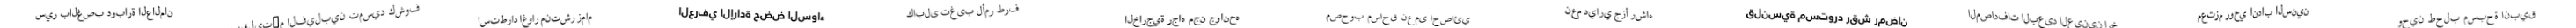

predictions ['ل ار ار اة', 'ل ار ار اة', 'ل ار ار اة', 'ل ار ار اة', 'ل ار ار اة', 'ل ار ار اة', 'ل ار ار اة', 'ل ار ار اة', 'ل ار ار اة', 'ل ار ار اة', 'ل ار ار اة', 'ل ار ار اة']
500/500 [==============================] - 285s 569ms/step - loss: 62.2650 - accuracy: 0.0000e+00
Epoch 10/20
500/500 [==============================] - ETA: 0s - loss: 62.1613 - accuracy: 0.0000e+00

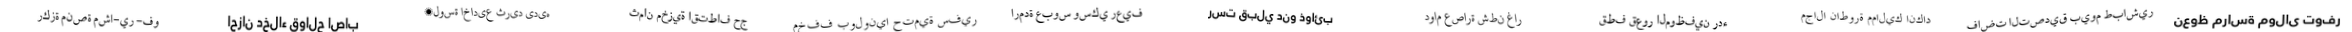

predictions ['ل ار ار اة', 'ل ار ار اة', 'ل ار ار اة', 'ل ار ار اة', 'ل ار ار اة', 'ل ار ار اة', 'ل ار ار اة', 'ل ار ار اة', 'ل ار ار اة', 'ل ار ار اة', 'ل ار ار اة', 'ل ار ار اة']
500/500 [==============================] - 269s 536ms/step - loss: 62.1613 - accuracy: 0.0000e+00
Epoch 11/20
500/500 [==============================] - ETA: 0s - loss: 62.0663 - accuracy: 0.0000e+00

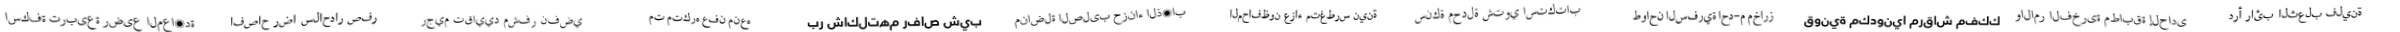

predictions ['ل ار ار اة', 'ل ار ار اة', 'ل ار ار اة', 'ل ار ار اة', 'ل ار ار اة', 'ل ار ار اة', 'ل ار ار اة', 'ل ار ار اة', 'ل ار ار اة', 'ل ار ار اة', 'ل ار ار اة', 'ل ار ار اة']
500/500 [==============================] - 261s 521ms/step - loss: 62.0663 - accuracy: 0.0000e+00
Epoch 12/20
500/500 [==============================] - ETA: 0s - loss: 61.9845 - accuracy: 0.0000e+00

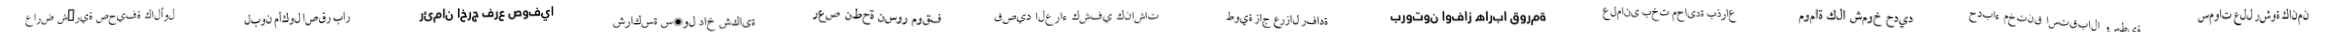

predictions ['ل ار ار راة', 'ل ار ار راة', 'ل ار ار راة', 'ل ار ار راة', 'ل ار ار راة', 'ل ار ار راة', 'ل ار ار راة', 'ل ار ار راة', 'ل ار ار راة', 'ل ار ار راة', 'ل ار ار راة', 'ل ار ار راة']
500/500 [==============================] - 253s 505ms/step - loss: 61.9845 - accuracy: 0.0000e+00
Epoch 13/20
500/500 [==============================] - ETA: 0s - loss: 61.9164 - accuracy: 0.0000e+00

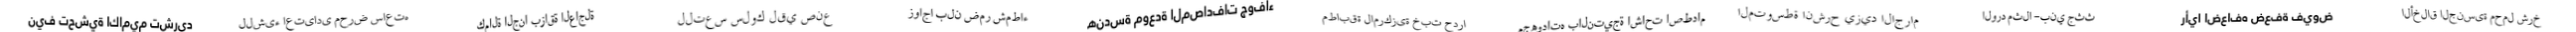

predictions ['ل ار ار راة', 'ل ار ار راة', 'ل ار ار راة', 'ل ار ار راة', 'ل ار ار راة', 'ل ار ار راة', 'ل ار ار راة', 'ل ار ار راة', 'ل ار ار راة', 'ل ار ار راة', 'ل ار ار راة', 'ل ار ار راة']
500/500 [==============================] - 250s 501ms/step - loss: 61.9164 - accuracy: 0.0000e+00
Epoch 14/20
500/500 [==============================] - ETA: 0s - loss: 61.8566 - accuracy: 0.0000e+00

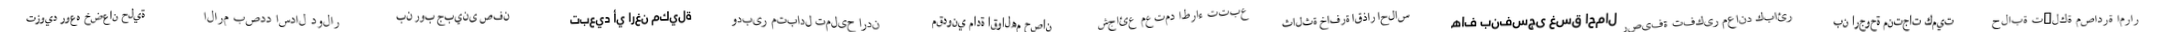

predictions ['لة رار ار راة', 'لة رار ار راة', 'لة رار ار راة', 'لة رار ار راة', 'لة رار ار راة', 'لة رار ار راة', 'لة رار ار راة', 'لة رار ار راة', 'لة رار ار راة', 'لة رار ار راة', 'لة رار ار راة', 'لة رار ار راة']
500/500 [==============================] - 257s 514ms/step - loss: 61.8566 - accuracy: 0.0000e+00
Epoch 15/20
500/500 [==============================] - ETA: 0s - loss: 61.8061 - accuracy: 0.0000e+00

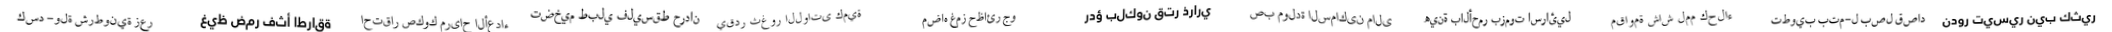

predictions ['لة رار ار راة', 'لة رار ار راة', 'لة رار ار راة', 'لة رار ار راة', 'لة رار ار راة', 'لة رار ار راة', 'لة رار ار راة', 'لة رار ار راة', 'لة رار ار راة', 'لة رار ار راة', 'لة رار ار راة', 'لة رار ار راة']
500/500 [==============================] - 254s 508ms/step - loss: 61.8061 - accuracy: 0.0000e+00
Epoch 16/20
500/500 [==============================] - ETA: 0s - loss: 61.7630 - accuracy: 0.0000e+00

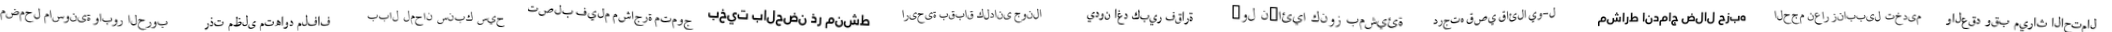

predictions ['لة رار ار راة', 'لة رار ار راة', 'لة رار ار راة', 'لة رار ار راة', 'لة رار ار راة', 'لة رار ار راة', 'لة رار ار راة', 'لة رار ار راة', 'لة رار ار راة', 'لة رار ار راة', 'لة رار ار راة', 'لة رار ار راة']
500/500 [==============================] - 241s 481ms/step - loss: 61.7630 - accuracy: 0.0000e+00
Epoch 17/20
500/500 [==============================] - ETA: 0s - loss: 61.7267 - accuracy: 0.0000e+00

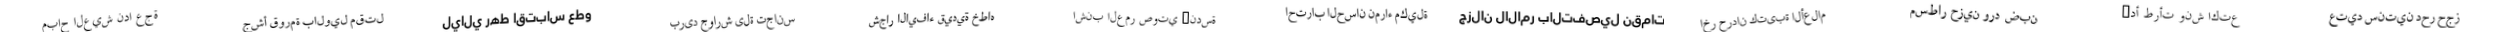

predictions ['لة رار ار راة', 'لة رار ار راة', 'لة رار ار راة', 'لة رار ار راة', 'لة رار ار راة', 'لة رار ار راة', 'لة رار ار راة', 'لة رار ار راة', 'لة رار ار راة', 'لة رار ار راة', 'لة رار ار راة', 'لة رار ار راة']
500/500 [==============================] - 234s 469ms/step - loss: 61.7267 - accuracy: 0.0000e+00
Epoch 18/20
500/500 [==============================] - ETA: 0s - loss: 61.6959 - accuracy: 0.0000e+00

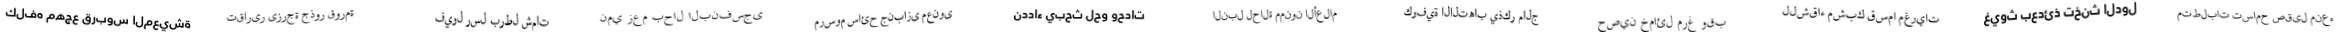

predictions ['لة رر ار راة', 'لة رر ار راة', 'لة رر ار راة', 'لة رر ار راة', 'لة رر ار راة', 'لة رر ار راة', 'لة رر ار راة', 'لة رر ار راة', 'لة رر ار راة', 'لة رر ار راة', 'لة رر ار راة', 'لة رر ار راة']
500/500 [==============================] - 265s 529ms/step - loss: 61.6959 - accuracy: 0.0000e+00
Epoch 19/20
 69/500 [===>..........................] - ETA: 3:39 - loss: 61.7306 - accuracy: 0.0000e+00

KeyboardInterrupt: 

In [13]:
H = model.fit(datagen, epochs=20, verbose=1, callbacks=[predvis, model_saver])

unfortunetally the model didnt perform well using english nor arabic text, so for our bot implementation we will be using ArabicOcr

In [32]:
image_path='scraped_imgs\\6.jpg'
out_image='out.jpg'
results=arabicocr.arabic_ocr(image_path,out_image)
print(results)
words=[]
for i in range(len(results)):
    word=results[i][1]
    words.append(word)
with open ('file.txt','w',encoding='utf-8')as myfile:
    myfile.write(str(words))

[INFO] OCR'ing input image...
[INFO] 0.8209: # تخيل _ اكثر
[INFO] 0.1389: 07(
[INFO] 0.1058: سن
[INFO] 0.1450: |٩٣
[INFO] 0.9788: قهوة
[INFO] 0.2481: more 
[INFO] 0.1477: العجم
[INFO] 0.9925: سوداء
[INFO] 0.9501: الخيال :
[INFO] 0.3357: الكبير
[INFO] 0.6124: 21 ريال
[INFO] 0.0104: ن
[INFO] 0.9934: توست
[INFO] 0.5265: الواقع :
[INFO] 0.7526: 13 ريال
[INFO] 0.6127: فستق .
[INFO] 0.5970: شوكولاتة بالبندق
[INFO] 0.9435: لبنة بالعسل
[INFO] 0.4838: توست لبنة بالبيستو
[INFO] 0.4679: لفترة محدودة حتى نفاد الكمية 
[INFO] 0.2602: DUNIIN
[[[[804, 33], [1169, 33], [1169, 125], [804, 125]], '# تخيل _ اكثر', 0.8208846126940333], [[[39, 130], [178, 130], [178, 166], [39, 166]], '07(', 0.13886100108289998], [[[37, 177], [59, 177], [59, 191], [37, 191]], 'سن', 0.10581156890624219], [[[51, 189], [161, 189], [161, 229], [51, 229]], '|٩٣', 0.14502450478148043], [[[327, 185], [450, 185], [450, 241], [327, 241]], 'قهوة', 0.9788346290588379], [[[93, 229], [139, 229], [139, 245], [93, 245]], 'more ', 0.248075

In [ ]:
from os import listdir
from os.path import isfile, join
mypath = 'scraped_imgs'
onlyfiles = [f for f in listdir(mypath) if isfile(join(mypath, f))]

In [ ]:
images_path='scraped_imgs\\'
out_image='out.jpg'
for pic in onlyfiles:
    results=arabicocr.arabic_ocr(images_path+pic,out_image)
    print(results)
    words=[]
    for i in range(len(results)):
            word=results[i][1]
            words.append(word)
    with open ('file.txt','a',encoding='utf-8')as myfile:
            myfile.write(str(words))
myfile.close()